In [23]:
import re
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from openTSNE import TSNE
from sklearn.decomposition import PCA
import pandas as pd 
from tqdm import tqdm

 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, auc
from openTSNE import TSNE

# from sklearn.manifold import TSNE
from openTSNE import TSNE
from gensim.models import Word2Vec
import networkx as nx 
from matplotlib.lines import Line2D
import pickle 
from itertools import combinations
%matplotlib inline

import gc 


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap

from scipy import interpolate
from scipy.spatial import ConvexHull
import matplotlib.colors as mcolors


In [24]:

plt.style.use('tableau-colorblind10')
def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "serif",
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

# Compare Baseline

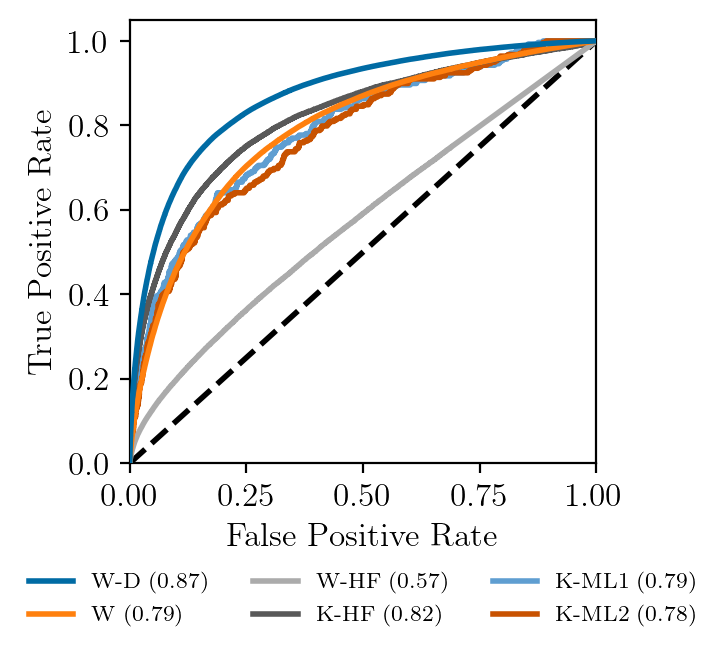

In [25]:
# Here we show the AUC values for different models that use machine learning techniques (ML),  or a combination thereof. 
# The left plot shows results for the prediction of a single new link (i.e., w = 1),
# the right one shows results for the prediction of new triple links w = 3. The task is to predict δ = [1, 3, 5] years into
# the future, with cutoff values c = [0, 5, 25]. We sort the models by the the results for the task (w = 1, δ = 3, c = 0),
# which was the task in the Science4Cast competition. Data points that are not shown have a AUC below 0.6 or are
# not computed due to computational costs. Note that the prediction of new triple edges can be performed nearly
# determinstically. It will be interesting to understand the origin of this quasi-deterministic pattern in AI research.


# Word Embedding (W) with time info 
# Word Embedding without time info 
# Word Embedding without time info and extracted feature 

# Knowledge Graph (K) with hand hand-crafted features (NF)
# Knowledge Graph (K) with pure ml (probe embedding)
# Knowledge Graph (K) with pure ml (node2vec embedding)

# our method W-T - Word Embedding with time info
fpr_method = np.load("saved_files/fpr_method_final.npy")
tpr_method = np.load("saved_files/tpr_method_final.npy")

# pred model based on cosine sim of concepts  
# W-NT+F - Word Embedding without time info + hand-crafted features
fpr_baseline_1 = np.load("saved_files/fpr_baseline_1.npy")
tpr_baseline_1 = np.load("saved_files/tpr_baseline_1.npy")

# method but static embedding 
# W-NT - Word Embedding without time info
fpr_baseline_2 = np.load("saved_files/fpr_baseline_2.npy")
tpr_baseline_2 = np.load("saved_files/tpr_baseline_2.npy")

# 15 hand crafted features 
# K+NF - Knowledge Graph with hand-crafted features
fpr_baseline_3 = np.load("saved_files/fpr_baseline_3.npy")
tpr_baseline_3 = np.load("saved_files/tpr_baseline_3.npy")


# prone
# K+PE - Knowledge Graph with pure ML (probe embedding)
fpr_baseline_4 = np.load("saved_files/fpr_baseline_4.npy")
tpr_baseline_4 = np.load("saved_files/tpr_baseline_4.npy")

# 1node2vec
# K+N2V - Knowledge Graph with pure ML (node2vec embedding)
fpr_baseline_5 = np.load("saved_files/fpr_baseline_5.npy")
tpr_baseline_5 = np.load("saved_files/tpr_baseline_5.npy")

from scipy.signal import savgol_filter



fig,axs = plt.subplots(figsize=(3.54331, 3.54331))
axs.plot(fpr_method, tpr_method, lw=2, label='W-D (%0.2f)' % auc(fpr_method, tpr_method),zorder=5)
axs.plot(fpr_baseline_2, tpr_baseline_2,  lw=2,  label='W  (%0.2f)' % auc(fpr_baseline_2, tpr_baseline_2),zorder=4)
axs.plot(fpr_baseline_1, tpr_baseline_1,  lw=2,  label='W-HF (%0.2f)' % auc(fpr_baseline_1, tpr_baseline_1),zorder=3)
axs.plot(fpr_baseline_3, tpr_baseline_3, lw=2, label='K-HF (%0.2f)' % auc(fpr_baseline_3, tpr_baseline_3),zorder=2)
axs.plot(fpr_baseline_4, tpr_baseline_4,  lw=2,  label='K-ML1 (%0.2f)' % auc(fpr_baseline_4, tpr_baseline_4),zorder=1)
axs.plot(fpr_baseline_5, tpr_baseline_5, lw=2, label='K-ML2 (%0.2f)' % auc(fpr_baseline_5, tpr_baseline_5),zorder=1)

axs.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=8, frameon=False)

plt.tight_layout()
fig.savefig("figures/roc.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [26]:
def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)

    return result

def flatten_matrix(matrix):
    flat = []
    for r in matrix:
        # for c in r:
        flat += r
    return np.unique(flat)

def compute_word_count_subset(corpus, subset_words):
    
    for document in tqdm(corpus):
        for word in document:
            if word in subset_words:
                subset_words[word] += 1
    return subset_words

In [27]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

c_inx_arr = np.memmap("saved_files/embedding_concept_arr.dat",shape=(10235,), dtype="<U55")
c_encoding_arr = np.memmap("saved_files/embedding_vector_arr.dat",shape=(10235, 30, 128), dtype=np.float64)


In [28]:
# Compute word count for the subset of words 
word_count_subset = compute_word_count_subset([row.split() for row in ngram_abstracts], {k:0 for k in np.unique(c_inx_arr)})

def filter_dict_by_occurrence(word_count_dict, n):
    return {word: count for word, count in word_count_dict.items() if count > n}

filtered_concept_dict = np.array(list(filter_dict_by_occurrence(word_count_subset, 4).keys()))

ocurr_arr = {}
for abstract, year in tqdm(zip(ngram_abstracts, year_arr)):
    temp = keep_words_with_underscore(abstract)
    if year not in ocurr_arr:
        ocurr_arr[year] = []
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in filtered_concept_dict]
        l = [list(filter(("_").__ne__, temp))]
        ocurr_arr[year].extend(l)

new_ocurr_arr = {}
for year in tqdm(np.unique(year_arr)):
    new_ocurr_arr[year] = flatten_matrix(ocurr_arr[year])

100%|██████████| 66839/66839 [00:00<00:00, 163797.06it/s]
66839it [00:11, 5627.28it/s]
100%|██████████| 30/30 [00:00<00:00, 103.66it/s]


In [29]:
occur_count_2012 = {k:0 for k in c_inx_arr}
for i in ocurr_arr[2012]:
    for j in i:
        occur_count_2012[j] += 1


occur_count_2022 = {k:0 for k in c_inx_arr}
for i in ocurr_arr[2022]:
    for j in i:
        occur_count_2022[j] += 1


In [30]:
def preprocess_connections(connections):
    all_pairs = set()  # Using a set to automatically avoid duplicates

    for group in connections:
        unique_words = list(set(group))  # Remove duplicates within each group
        # Generate all possible pairs (combinations of 2) from the unique words
        for pair in combinations(unique_words, 2):
            # Sort the pair to enforce permutation invariance
            sorted_pair = tuple(sorted(pair))
            all_pairs.add(sorted_pair)
    return list(all_pairs)

# Get the processed connections
processed_connections_2012 = preprocess_connections(ocurr_arr[2012])
processed_connections_2022 = preprocess_connections(ocurr_arr[2022])
# Output the unique pairs
print(len(processed_connections_2012))
print(len(processed_connections_2022))

28958
78787


In [31]:
# Dictionary to store the first occurrence year of each word
first_occurrences = {}

# Dictionary to count the number of first occurrences per year
new_words_per_year = {}

# Iterate through the years in sorted order
for year in sorted(new_ocurr_arr.keys()):
    new_words_count = 0
    for word in new_ocurr_arr[year]:
        if word not in first_occurrences:
            first_occurrences[word] = year
            new_words_count += 1
    new_words_per_year[year] = new_words_count

years = sorted(new_words_per_year.keys())
cumulative_sum = [sum(new_words_per_year[y] for y in years if y <= year) for year in years]

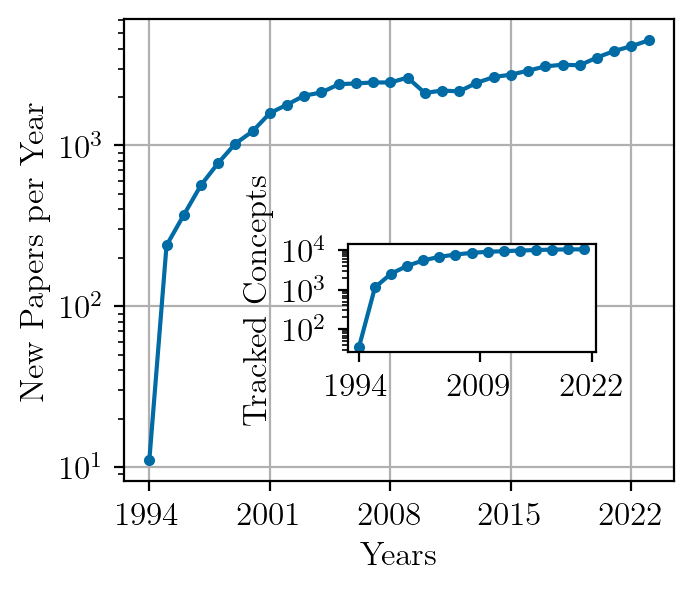

In [32]:
years, numpapers_y = np.unique(year_arr,return_counts=True)
fig, ax = plt.subplots(figsize=(3.54331, 3.0))

ax.plot( years, numpapers_y[:], '-o', markersize=3 )
ax.set_xticks(years[::7])
# ax.set_xticklabels( years[::4], rotation=45 )
ax.set_yscale("log")
ax.set_ylabel("New Papers per Year")
ax.grid(True)
ax.set_xlabel("Years")

ax2 = fig.add_axes([0.44, 0.25+0.075, 0.25+0.1, 0.18])
ax2.plot(np.arange(len(numpapers_y))[:-1][::2], cumulative_sum[:-1][::2], '-o', markersize=3)
# ax2.grid(True)
# ax2.set_xticks( list(range(len(years))[::7]))
# ax2.set_xticklabels( years[::7], rotation=45 )
ax2.set_xticks( [0,15,29])
ax2.set_xticklabels( [1994,2009,2022] )


ax2.set_yscale("log")
ax2.set_ylabel("Tracked Concepts")
# fig.tight_layout()
fig.savefig("figures/c_per_year.pdf", format="pdf", bbox_inches="tight")

# Plotting Def

In [33]:
def cluster_embeddings(vectors, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters,n_init="auto",random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    return clusters, kmeans.cluster_centers_

def reduce_dimensions(vectors, second_vectors=np.empty(0), method='UMAP'):
    if method == 'PCA':
        pca = PCA(n_components=2)
        if second_vectors.size == 0:
            return pca.fit_transform(vectors)
        else: 
            return pca.fit_transform(vectors), pca.transform(second_vectors)
        
    elif method == 't-SNE':
        tsne = TSNE(n_components=2,perplexity=30,learning_rate=200,random_state=42)
        if second_vectors.size == 0:
            return tsne.fit_transform(vectors)
        else: 
            return tsne.fit_transform(vectors), tsne.fit_transform(second_vectors)
    
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2,n_neighbors=15, min_dist=0.9)
        if second_vectors.size == 0:
            return reducer.fit_transform(vectors)
        else: 
            return reducer.fit_transform(vectors), reducer.transform(second_vectors)

def find_closest_point(coord, points):
    # Convert to NumPy arrays for vectorized operations
    coord = np.array(coord)
    points = np.array(points)
    
    # Compute Euclidean distances: ||point - coord||
    distances = np.linalg.norm(points - coord, axis=1)
    
    # Find the index of the minimum distance
    closest_index = np.argmin(distances)
    
    # Return the closest point
    return points[closest_index]

In [34]:
# def plot_clusters_2d(reduced_vectors, words, clusters, connections, word_count, centers):
#     # Create the figure and axis
#     plt.figure(figsize=(10, 10))

#     # Scatter plot of the reduced vectors, colored by clusters
#     plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='Spectral', s=10, alpha=0.6,zorder=3)

#     # Get the unique cluster labels
#     unique_clusters = np.unique(clusters)
    
#     # Colors for each cluster (for plotting the convex hulls)
#     colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

#     # Plot the convex hulls for each cluster
#     for i, cluster in enumerate(unique_clusters):
#         # Get points belonging to this cluster
#         points = reduced_vectors[clusters == cluster]
#         cluster_words = words[clusters==cluster]
        
#         top_5 = sorted(cluster_words, key=lambda cw: word_count[cw], reverse=True)[:5]
        
        
#         if len(points) > 2:  # Convex hull requires at least 3 points
#             hull = ConvexHull(points)
#             x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
#             y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
            
#             # Interpolate the boundary of the convex hull for smoothness
#             dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
#             dist_along = np.concatenate(([0], dist.cumsum()))
#             spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
#             interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
#             interp_x, interp_y = interpolate.splev(interp_d, spline)
            
#             # Plot the convex hull as a filled shape
#             plt.plot(interp_x, interp_y, '--', c=colors[i], alpha=1,zorder=3)
            
#             center_x, center_y = centers[i]

#             # Vertical offset between stacked words
#             vertical_offset = 2.5  # Adjust this value as needed for spacing
#             horizontal_offset = 0
#             # Plot the top 5 words, stacked and aligned at the center
#             for idx, word_ in enumerate(top_5):
#                 x = center_x -horizontal_offset # Align all words to the center horizontally
#                 y = center_y + (idx-1.5) * vertical_offset  # Stack words by adjusting the y-coordinate
                
#                 plt.text(x, y, word_.replace("_", " ").title(), color='black', fontsize=10, 
#                         bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='none'), zorder=3,horizontalalignment='center')


#     # Plot connections (edges) between words based on the connections array
#     for conn in connections:
#         word1, word2 = conn
#         idx1 = np.where(words==word1)[0][0]
#         idx2 = np.where(words==word2)[0][0]
#         plt.plot([reduced_vectors[idx1, 0], reduced_vectors[idx2, 0]], 
#                  [reduced_vectors[idx1, 1], reduced_vectors[idx2, 1]], color='lightgray', lw=0.5, zorder=1)

#     # Remove the axis ticks for a cleaner look
#     plt.xticks([])
#     plt.yticks([])
    
#     # Add title and layout settings
#     plt.tight_layout()
#     plt.show()

# def plot_most_sim_2d(reduced_vectors, words, clusters, connections, word_count, centers, model):
#     # Create the figure and axis
#     plt.figure(figsize=(10, 10))

#     # Scatter plot of the reduced vectors, colored by clusters
#     plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='Spectral', s=10, alpha=0.6,zorder=3)

#     # Get the unique cluster labels
#     unique_clusters = np.unique(clusters)
    
#     # Colors for each cluster (for plotting the convex hulls)
#     colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

#     # Plot the convex hulls for each cluster
#     for i, cluster in enumerate(unique_clusters):
#         # Get points belonging to this cluster
#         points = reduced_vectors[clusters == cluster]
#         cluster_words = words[clusters==cluster]
        
#         # top_5 = sorted(cluster_words, key=lambda cw: word_count[cw], reverse=True)[:5]
        
        
#         if len(points) > 2:  # Convex hull requires at least 3 points
#             hull = ConvexHull(points)
#             x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
#             y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
            
#             # Interpolate the boundary of the convex hull for smoothness
#             dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
#             dist_along = np.concatenate(([0], dist.cumsum()))
#             spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
#             interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
#             interp_x, interp_y = interpolate.splev(interp_d, spline)
            
#             # Plot the convex hull as a filled shape
#             plt.plot(interp_x, interp_y, '--', c=colors[i], alpha=1,zorder=3)
            
            
#             center_x, center_y = centers[i]
            
#             top_30 = [cluster_words[np.where(points==find_closest_point(centers[i], points))[0][0]]]
#             top_30.extend( np.array(model.wv.most_similar(positive=[cluster_words[np.where(points==find_closest_point(centers[i], points))[0][0]]], topn=30))[:,0])
            
#             top_5 = [word for word in top_30 if word in c_inx_arr][:5]

            

#             # Vertical offset between stacked words
#             vertical_offset = 2.5  # Adjust this value as needed for spacing
#             horizontal_offset = 0
#             # Plot the top 5 words, stacked and aligned at the center
#             for idx, word_ in enumerate(top_5):
#                 x = center_x -horizontal_offset # Align all words to the center horizontally
#                 y = center_y + (idx-1.5) * vertical_offset  # Stack words by adjusting the y-coordinate
                
#                 plt.text(x, y, word_.replace("_", " ").title(), color='black', fontsize=10, 
#                         bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='none'), zorder=3,horizontalalignment='center')


#     # Plot connections (edges) between words based on the connections array
#     for conn in connections:
#         word1, word2 = conn
#         idx1 = np.where(words==word1)[0][0]
#         idx2 = np.where(words==word2)[0][0]
#         plt.plot([reduced_vectors[idx1, 0], reduced_vectors[idx2, 0]], 
#                  [reduced_vectors[idx1, 1], reduced_vectors[idx2, 1]], color='lightgray', lw=0.5, zorder=1)

#     # Remove the axis ticks for a cleaner look
#     plt.xticks([])
#     plt.yticks([])
    
#     # Add title and layout settings
#     plt.tight_layout()
#     plt.show()



# Cluster First

In [35]:
# gc.collect()
# model_w2v_2012 = Word2Vec.load("saved_w2v_models/model_single_{}.model".format(2012)) 
# model_w2v_2022 = Word2Vec.load("saved_w2v_models/model_single_{}.model".format(2022)) 

model_w2v_2012 = Word2Vec.load("saved_w2v_models/re_model_year_{}.model".format(2012)) 
model_w2v_2022 = Word2Vec.load("saved_w2v_models/re_model_year_{}.model".format(2022)) 

encoding_arr_2012 = np.array([model_w2v_2012.wv.get_vector(w) for w in filtered_concept_dict if w in model_w2v_2012.wv])
encoding_arr_2022 = np.array([model_w2v_2022.wv.get_vector(w) for w in filtered_concept_dict if w in model_w2v_2022.wv])

red_arr_2012 = np.array([w for w in filtered_concept_dict if w in model_w2v_2012.wv])
red_arr_2022 = np.array([w for w in filtered_concept_dict if w in model_w2v_2022.wv])
gc.collect()


19921

In [36]:
# umap_2012 = umap.UMAP(n_components=2, random_state=42, metric="cosine",n_neighbors=10,min_dist=0.1) #random_state=42,n_neighbors=10,min_dist=0.1,metric="cosine"
# d2_encoding_arr_2012 = umap_2012.fit_transform(encoding_arr_2012)

# umap_2022 = umap.UMAP(n_components=2, random_state=44, metric="cosine",n_neighbors=10,min_dist=0.1)
# d2_encoding_arr_2022 = umap_2022.fit_transform(encoding_arr_2022)

In [37]:
# kmeans_2012 = KMeans(n_clusters=8, random_state=42, n_init="auto") 
# kmeans_2022 = KMeans(n_clusters=8, random_state=42, n_init="auto") 

# labels_2012 = kmeans_2012.fit_predict(d2_encoding_arr_2012)
# labels_2022 = kmeans_2022.fit_predict(d2_encoding_arr_2022)

# centers_2012 = kmeans_2012.cluster_centers_
# centers_2022 = kmeans_2022.cluster_centers_

In [38]:
# central_words_2012 = []
# central_plus_surrounding_2012 = {}
# for i, label in enumerate(np.unique(labels_2012)):
#     points = d2_encoding_arr_2012[labels_2012 == label]
#     cluster_words = red_arr_2012[labels_2012 == label]
#     center_x, center_y = centers_2012[i]
#     central_word = cluster_words[np.where(points == find_closest_point(centers_2012[i], points))[0][0]]
#     central_words_2012.append(central_word)

#     top_surrounding_2012 = np.array(model_w2v_2012.wv.most_similar(positive=[central_word], topn=200))[:, 0]
#     top_surrounding_2012 = [word for word in top_surrounding_2012 if word in red_arr_2012]
#     top_surrounding_2012 = sorted(top_surrounding_2012, key=lambda x: occur_count_2012[x], reverse=True)[:100]
#     central_plus_surrounding_2012[central_word] = top_surrounding_2012
    
    


# central_words_2022 = []
# central_plus_surrounding_2022 = {}
# for i, label in enumerate(np.unique(labels_2022)):
#     points = d2_encoding_arr_2022[labels_2022 == label]
#     cluster_words = red_arr_2022[labels_2022 == label]
#     center_x, center_y = centers_2022[i]
#     central_word = cluster_words[np.where(points == find_closest_point(centers_2022[i], points))[0][0]]
#     central_words_2022.append(central_word)

#     top_surrounding_2022 = np.array(model_w2v_2022.wv.most_similar(positive=[central_word], topn=200))[:, 0]
#     top_surrounding_2022 = [word for word in top_surrounding_2022 if word in red_arr_2022]
#     top_surrounding_2022 = sorted(top_surrounding_2022, key=lambda x: occur_count_2022[x], reverse=True)[:100]
#     central_plus_surrounding_2022[central_word] = top_surrounding_2022


  

In [39]:
# for k,v in central_plus_surrounding_2012.items():
#     print(k,v[:3])

# print("\n")

# for k,v in central_plus_surrounding_2022.items():
#     print(k,v[:3])

In [40]:
# embedding_clusters = []

# # Loop through words in dict_2012 and retrieve their embeddings
# for word in central_words_2012:
#     cluster_embeddings = []  
  
#     word_embedding = model_w2v_2012.wv.get_vector(word)
#     cluster_embeddings.append(word_embedding)
    
#     for similar_word, _ in model_w2v_2012.wv.most_similar(word, topn=14):      
#         similar_word_embedding = model_w2v_2012.wv.get_vector(similar_word)
#         cluster_embeddings.append(similar_word_embedding)

#     embedding_clusters.append(np.array(cluster_embeddings))  
# embedding_clusters = np.array(embedding_clusters)

# n, m, k = embedding_clusters.shape
# umap_data_2d_2012 = np.array(umap_2012.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# embedding_clusters = []
# for word in central_words_2022:
#     cluster_embeddings = []  
  
#     word_embedding = model_w2v_2022.wv.get_vector(word)
#     cluster_embeddings.append(word_embedding)
    
#     for similar_word, _ in model_w2v_2022.wv.most_similar(word, topn=13):      
#         similar_word_embedding = model_w2v_2022.wv.get_vector(similar_word)
#         cluster_embeddings.append(similar_word_embedding)

#     embedding_clusters.append(np.array(cluster_embeddings))  
# embedding_clusters = np.array(embedding_clusters)

# n, m, k = embedding_clusters.shape
# umap_data_2d_2022 = np.array(umap_2022.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [41]:
# import matplotlib.pyplot as plt

# # Example list of words for each category (replace with your actual word lists)
# dict_2012 = {
#     "C0": ["erasure channel", "butterfly network", "quantum fingerprinting"],
#     "C1": ["polarization multiplexing", "laser pumping", "quantum repeater"],
#     "C2": ["phase noise", "laser linewidth", "cavity resonance"],
#     "C3": ["gaussian wavepacket", "quantum propagator", "coherent state"],
#     "C4": ["quantum memory", "quantum processor", "quantum computation"],
#     "C5": ["gallium arsenide", "nitrogen atom", "quantum dot emission"],
#     "C6": ["clifford group", "quantum compiler", "anyonic model"],
#     "C7": ["compton scattering", "kapitza dirac effect", "electron interferometer"],
# }

# dict_2022 =  {
#     "C0": ["electric field", "charged particle", "electron wave"],
#     "C1": ["dressed state", "rabi oscillation", "vacuum splitting"],
#     "C2": ["laser interferometer", "gravitational wave", "squeezed quadrature"],
#     "C3": ["quantum computer", "quantum speedup", "quantum_supremacy"],
#     "C4": ["photonic integration", "satellite communication", "network capacity"],
#     "C5": ["quantum logic", "boolean algebra", "logical connective"],
#     "C6": ["silicon quantum dot", "electron spin resonance", "metal oxide semiconductor"],
#     "C7": ["quantum chaotic", "prethermal state", "ergodic system"],
# }


# # Set up the figure
# fig, axs = plt.subplots(2, 1, figsize=(7.48031/2, 7.48031 // 2))

# # Define color palette
# colors = plt.cm.tab20.colors

# # Plot the first set of points with consistent colors
# for i in range(8):
#     axs[0].scatter(umap_data_2d_2012[i, :, 0], umap_data_2d_2012[i, :, 1],
#                    color=colors[i], label=f'Category {i+1}', alpha=1)

# axs[0].set_xticks([])
# axs[0].set_yticks([])

# # Prepare legend entries
# legend_labels_2012 = [f"{', '.join(words)}" for words in dict_2012.values()]
# handles_2012 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, 
#                           label=legend_labels_2012[i]) for i in range(8)]

# # Place the legend below the plot with two columns, reduced font size
# axs[0].legend(handles=handles_2012, loc='upper center', bbox_to_anchor=(0.5, -0.35),
#               frameon=False, ncol=1, fontsize=5)

# ############################
# # Plot the second set of points with consistent colors
# for i in range(8):
#     axs[1].scatter(umap_data_2d_2022[i, :, 0], umap_data_2d_2022[i, :, 1],
#                    color=colors[i], label=f'Category {i+1}', alpha=1)

# axs[1].set_xticks([])
# axs[1].set_yticks([])

# # Prepare legend entries
# legend_labels_2022 = [f"{', '.join(words)}" for words in dict_2022.values()]
# handles_2022 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, 
#                           label=legend_labels_2022[i]) for i in range(8)]

# # Place the legend below the plot with two columns, reduced font size
# axs[1].legend(handles=handles_2022, loc='upper center', bbox_to_anchor=(0.5, -0.35),
#               frameon=False, ncol=1, fontsize=5)

# # Adjust space to fit legends without overlap
# # plt.subplots_adjust(bottom=0.5)
# plt.show()


In [42]:
# import matplotlib.pyplot as plt

# # Set up the figure for a single-column layout with four rows (two for plots and two for legends)
# fig, axs = plt.subplots(4, 1, figsize=(7.48031/2, 7.48031), gridspec_kw={'height_ratios': [3, 1, 3, 1]})

# # Define color palette
# colors = plt.cm.tab20.colors

# # Plot the first set of points
# for i in range(8):
#     axs[0].scatter(umap_data_2d_2012[i, :, 0], umap_data_2d_2012[i, :, 1],
#                    color=colors[i], label=f'Category {i+1}', alpha=1)

# axs[0].set_xticks([])
# axs[0].set_yticks([])

# # Prepare legend entries for the first plot
# legend_labels_2012 = [f"{', '.join(words)}" for words in dict_2012.values()]
# handles_2012 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, 
#                           label=legend_labels_2012[i]) for i in range(8)]

# # Place the legend below the first plot
# axs[1].legend(handles=handles_2012, loc='center', frameon=False, ncol=1, fontsize=8)
# axs[1].axis('off')  # Hide the axis for the legend area

# ############################
# # Plot the second set of points
# for i in range(8):
#     axs[2].scatter(umap_data_2d_2022[i, :, 0], umap_data_2d_2022[i, :, 1],
#                    color=colors[i], label=f'Category {i+1}', alpha=1)

# axs[2].set_xticks([])
# axs[2].set_yticks([])

# # Prepare legend entries for the second plot
# legend_labels_2022 = [f"{', '.join(words)}" for words in dict_2022.values()]
# handles_2022 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, 
#                           label=legend_labels_2022[i]) for i in range(8)]

# # Place the legend below the second plot
# axs[3].legend(handles=handles_2022, loc='center', frameon=False, ncol=1, fontsize=8)
# axs[3].axis('off')  # Hide the axis for the legend area

# # Adjust layout to ensure good spacing
# plt.tight_layout()
# plt.show()


In [43]:
# import numpy as np
# import umap
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# # Sample word2vec embeddings (replace with your own embeddings)

# # Step 1: Dimensionality reduction with UMAP


# Step 2 (Alternative): Clustering with KMeans
# kmeans = KMeans(n_clusters=None, random_state=42)  # Set the number of clusters

# from sklearn.cluster import Birch
# # models = [('DBSCAN', ) for n in np.arange(2,2*9,2)]

# kmeans = Birch(n_clusters=8)
# labels_kmeans = kmeans.fit_predict(reduced_embeddings)

# # Visualizing the KMeans clusters
# plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels_kmeans, s=1)
# plt.colorbar()
# plt.title("UMAP + KMeans Clustering")
# plt.xlabel("UMAP Dimension 1")
# plt.ylabel("UMAP Dimension 2")
# plt.show()



In [44]:
# reducer = umap.UMAP(n_components=2,n_neighbors=30, min_dist=0.2,metric="cosine",random_state=42)
# r = reducer.fit_transform(encoding_arr_2012)

# model = KMeans(n_clusters=8, random_state=42, n_init="auto")
# clusters = model.fit_predict(r)

# # means.cluster_centers_



# plt.scatter(r[:,0],r[:,1],s=1,c=clusters)

In [45]:

# dict_2012 = {
#     "C0": ["erasure_channel"],
#     "C1": ["laser_pumping"],
#     "C2": ["phase_noise"],
#     "C3": ["gaussian_wavepacket"],
#     "C4": ["quantum_memory"],
#     "C5": ["gallium_arsenide"],
#     "C6": ["clifford_group"],
#     "C7": ["compton_scattering"],
#     "C8": ["white_gaussian_noise"]
# }



In [46]:
# clusters_2012_high, centers_2012_high = cluster_embeddings(encoding_arr_2012)
# reduced_vectors_2012, centers_2012_high_reduced = reduce_dimensions(encoding_arr_2012, second_vectors=centers_2012_high, method = 'UMAP')

# clusters_2022_high, centers_2022_high = cluster_embeddings(encoding_arr_2022)
# reduced_vectors_2022, centers_2022_high_reduced = reduce_dimensions(encoding_arr_2022, second_vectors=centers_2022_high, method = 'UMAP')

# plot_clusters_2d(reduced_vectors_2012, red_arr_2012[:], clusters_2012_high, processed_connections_2012[::20], occur_count_2012, centers_2012_high_reduced)
# plot_clusters_2d(reduced_vectors_2022, red_arr_2022[:], clusters_2022_high, processed_connections_2022[::20], occur_count_2022, centers_2022_high_reduced)


# Cluster

In [48]:
reduced_vectors_2012 = reduce_dimensions(encoding_arr_2012)
reduced_vectors_2022 = reduce_dimensions(encoding_arr_2022)

In [ ]:
from scipy.ndimage import gaussian_filter1d
def find_elbow_point(reduced_vectors, k_range):
    inertia_arr = []

    # Loop through models, fit, and calculate inertia
    for n in k_range:
        model = KMeans(n_clusters=n, random_state=42, n_init="auto")
        model.fit(reduced_vectors)
        inertia_arr.append(model.inertia_)

    # # Compute the first and second differences of inertia
    # first_diff = np.diff(inertia_arr)
    # second_diff = np.diff(first_diff)

    # # Find the "elbow" point (where the second derivative is near zero)
    # # elbow_index = np.argmin(second_diff) + 1  # Add 1 because of the diff operation
    # smooth_sigma=0.5
    # threshold_factor=0.05
    # smoothed_second_diff = gaussian_filter1d(second_diff, sigma=smooth_sigma)

    # # Find the "elbow" point (where the smoothed second derivative is near zero)
    # # You can adjust the threshold_factor to increase or decrease the sensitivity of the elbow detection
    # threshold = np.max(np.abs(smoothed_second_diff)) * threshold_factor
    # elbow_index = np.argmax(np.abs(smoothed_second_diff) < threshold) + 1  # Add 1 due to diff operation


    # Plot inertia and mark the elbow point
    plt.plot(k_range, inertia_arr, 'bx-')
    # plt.axvline(x=elbow_index, color='r', linestyle='--', label=f'Elbow at k={elbow_index}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.legend()
    plt.show()

# find_elbow_point(reduced_vectors_2012, np.arange(2, 2 * 9, 1))
# find_elbow_point(reduced_vectors_2022, np.arange(2, 2 * 9, 1))

In [49]:
clusters_2012, centers_2012 = cluster_embeddings(reduced_vectors_2012,n_clusters=9)

clusters_2022, centers_2022 = cluster_embeddings(reduced_vectors_2022,n_clusters=9)

In [ ]:
# plot_clusters_2d(reduced_vectors_2012, red_arr_2012[:], clusters_2012, processed_connections_2012[::20], occur_count_2012, centers_2012)
# plot_clusters_2d(reduced_vectors_2022, red_arr_2022[:], clusters_2022, processed_connections_2022[::20], occur_count_2022,centers_2022)

In [ ]:
# plot_most_sim_2d(reduced_vectors_2012, red_arr_2012[:], clusters_2012, processed_connections_2012[::20], occur_count_2012,centers_2012, model_w2v_2012)
# plot_most_sim_2d(reduced_vectors_2022, red_arr_2022[:], clusters_2022, processed_connections_2022[::20], occur_count_2022,centers_2022, model_w2v_2022)


In [ ]:
# def plot_style():

#     params = {'font.family': "serif",
#               'text.usetex': True
#              }

#     plt.rcParams.update(params)
# plot_style()

In [50]:
def plot_most_sim_2d_double(reduced_vectors_2012, words_2012, clusters_2012, connections_2012, word_count_2012, centers_2012, model_2012,
                            reduced_vectors_2022, words_2022, clusters_2022, connections_2022, word_count_2022, centers_2022, model_2022):
    # Create the figure and two subplots (side by side)
    fig, axes = plt.subplots(2, 2, figsize=(7, 3.5), )  # figsize for a double column plot

    # First plot for 2012 data
    conc_dict_2012 = plot_most_sim_2d_single(axes[0,0], reduced_vectors_2012, words_2012, clusters_2012, connections_2012, word_count_2012, centers_2012, model_2012,"Blues")
    
    # Second plot for 2022 data
    conc_dict_2022 = plot_most_sim_2d_single(axes[0,1], reduced_vectors_2022, words_2022, clusters_2022, connections_2022, word_count_2022, centers_2022, model_2022,"Oranges")

    axes[0,0].text(0.95+0.01, 0.05-0.01, '2012', transform=axes[0,0].transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='right', 
             bbox=dict(facecolor='white', alpha=0.0))

    # For the 2022 subplot
    axes[0,1].text(0.95+0.01, 0.05-0.01, '2022', transform=axes[0,1].transAxes, fontsize=8,
                verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(facecolor='white', alpha=0.0))
    
    add_cluster_boxes(axes[1,0], conc_dict_2012)
    add_cluster_boxes(axes[1,1], conc_dict_2022)
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # plt.savefig("/home/felix/Downloads/figure_cluster.pdf", format="pdf", bbox_inches="tight",dpi=200)
    plt.show()
    gc.collect()

def add_cluster_boxes(ax, wdict):
    cluster_labels = list(wdict.keys())
    word_lists = list(wdict.values())
    # Create textboxes for each cluster label and associated words
    for i, (cluster, words) in enumerate(zip(cluster_labels, word_lists)):
        # Position each text box
        ax.text(0.1, 1 - 0.1 * (i + 1), f'{cluster}: ' + ', '.join(words), 
                fontsize=10, ha='left', va='top', transform=ax.transAxes)

def plot_most_sim_2d_single(ax, reduced_vectors, words, clusters, connections, word_count, centers, model,cmap):
    
    unique_clusters = np.unique(clusters)
    if cmap == "Blues":
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Blues', plt.cm.Blues(np.linspace(0.2, 1, 256)))

    else: 
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Oranges', plt.cm.Oranges(np.linspace(0.2, 1, 256)))

    ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap=new_cmap, s=5, alpha=1, zorder=3)
    
    conc_dict = {}
    
    # Plot the convex hulls for each cluster
    for i, cluster in enumerate(unique_clusters):
        points = reduced_vectors[clusters == cluster]
        cluster_words = words[clusters == cluster]
        center_x, center_y = centers[i]
        top_30 = [cluster_words[np.where(points == find_closest_point(centers[i], points))[0][0]]]
        top_30.extend(np.array(model.wv.most_similar(positive=[top_30[0]], topn=20))[:, 0])
        top_ = [word for word in top_30 if word in words]
        
        print("C"+str(i))
        print(sorted(top_, key=lambda x: word_count[x], reverse=True))
        print("\n")
        top_5 = [word for word in top_30 if word in words][:3]
        conc_dict["C"+str(i)] = [word_.replace("_", " ").title() for word_ in top_5]
        text_str = "\n".join([word_.replace("_", " ").title() for word_ in top_5])
        text_str = "C"+str(i)
        x = center_x
        y = center_y 
        ax.text(x, y, text_str, color='black', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.95, edgecolor='none',boxstyle='round,pad=0.5'), zorder=3, horizontalalignment='center')

    ax.set_xticks([])
    ax.set_yticks([])
    return conc_dict 
    
# plot_most_sim_2d_double(reduced_vectors_2012, red_arr_2012, clusters_2012, processed_connections_2012[::20], occur_count_2012, centers_2012, model_w2v_2012,
#                             reduced_vectors_2022, red_arr_2022, clusters_2022, processed_connections_2022[::20], occur_count_2022, centers_2022, model_w2v_2022)



In [51]:
def plot_most_sim_2d_single(ax, reduced_vectors, words, clusters,  word_count, centers, model,cmap, letter):
    
    unique_clusters = np.unique(clusters)
    if cmap == "Blues":
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Blues', plt.cm.Blues(np.linspace(0.2, 1, 256)))

    else: 
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Oranges', plt.cm.Oranges(np.linspace(0.2, 1, 256)))

    ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap=new_cmap, s=5, alpha=1, zorder=3)
    
    
    
    # Plot the convex hulls for each cluster
    for i, cluster in enumerate(unique_clusters):
        points = reduced_vectors[clusters == cluster]
        cluster_words = words[clusters == cluster]
        center_x, center_y = centers[i]
        top_30 = [cluster_words[np.where(points == find_closest_point(centers[i], points))[0][0]]]
        top_30.extend(np.array(model.wv.most_similar(positive=[top_30[0]], topn=20))[:, 0])
        top_ = [word for word in top_30 if word in words]
        
        # print("C"+str(i))
        # print(sorted(top_, key=lambda x: word_count[x], reverse=True))
        # print("\n")
        top_5 = [word for word in top_30 if word in words][:]
        print(top_5)
        print("\n")


        text_str = "\n".join([word_.replace("_", " ").title() for word_ in top_5])
        text_str = letter+str(i)
        x = center_x
        y = center_y 
        ax.text(x, y, text_str, color='black', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.95, edgecolor='none',boxstyle='round,pad=0.5'), zorder=3, horizontalalignment='center')

    ax.set_xticks([])
    ax.set_yticks([])
   

In [ ]:
# np.save("2012_vectors.npy",reduced_vectors_2012)
# np.save("2012_concepts.npy",red_arr_2012)
# np.save("2012_clusters.npy",clusters_2012)

# np.save("2022_vectors.npy",reduced_vectors_2022)
# np.save("2022_concepts.npy",red_arr_2022)
# np.save("2022_clusters.npy",clusters_2022)

['quantum_magnetism', 'trapped_ion_crystal', 'local_quantum_circuit', 'energy_efficiency', 'optimisation_method', 'long_range', 'topological_quantum_computing', 'quantum_surface', 'memory_capacity', 'rectangular_lattice', 'variational_method', 'superconducting_technology', 'continuous_phase', 'zero_crossing', 'brillouin_zone', 'dynamic_range', 'high_fidelity_quantum_operation', 'bell_test_experiment']


['peres_horodecki_criterion', 'partial_transposition', 'positive_partial_transpose', 'entangled_gaussian_state', 'partial_transpose', 'characteristic_function', 'separability_problem', 'werner_state', 'continuous_variable', 'quantify_entanglement', 'optimal_entanglement_witness', 'bipartite_quantum_system']


['steady_state_solution', 'number_representation', 'langevin_equation', 'fokker_planck_equation', 'deformation_function', 'optical_parametric_oscillator', 'fluctuation_spectrum', 'phase_locked', 'master_equation', 'multiplicative_noise', 'laplace_transform', 'wkb_method', 'frequenc

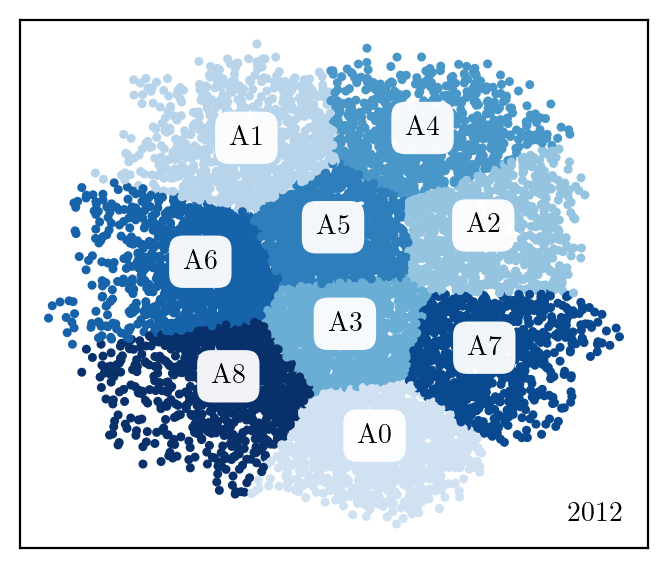

['magnetic_interaction', 'valence_electron', 'trapped_electron', 'spin_orbit_interaction', 'spin_coupling', 'magnetic_noise', 'magnetic_moment', 'cyclotron_motion', 'zeeman_effect', 'applied_magnetic_field', 'magnetic_field', 'coulomb_blockade', 'molecular_spin', 'pseudo_vector', 'magnetic_dipole_interaction', 'spin_entanglement']


['secret_key_distillation', 'unconditionally_secure_communication', 'microwave_technology', 'bit_length', 'symmetric_encryption', 'secret_key_agreement', 'photon_number_splitting', 'public_discussion', 'high_quality_entanglement', 'wavelength_multiplexing', 'high_dimensional_quantum_key_distribution']


['optimal_measurement_strategy', 'minimum_error_probability', 'state_discrimination', 'optimal_quantum_measurement', 'quantum_state_discrimination', 'single_shot', 'kennedy_receiver', 'optimal_measurement_operator', 'priori_probability', 'optimal_unambiguous_discrimination', 'semidefinite_program', 'type_ii_error', 'pure_state']


['photon_jaynes_cummings_mo

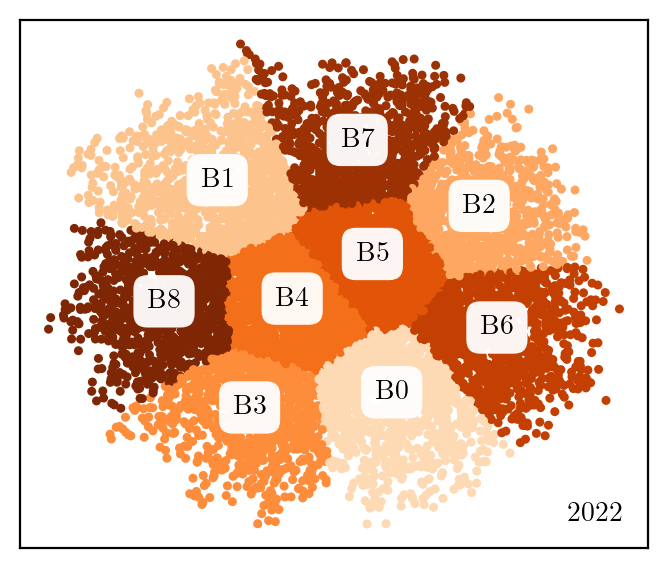

2884

In [52]:

fig, axes = plt.subplots( figsize=(3.5, 3))  

# First plot for 2012 data
plot_most_sim_2d_single(axes, reduced_vectors_2012, red_arr_2012, clusters_2012,  occur_count_2012, centers_2012, model_w2v_2012,"Blues","A")

axes.text(0.95+0.01, 0.05-0.01, '2012', transform=axes.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(facecolor='white', alpha=0.0))

plt.tight_layout()
plt.savefig("figures/cluster2012.pdf", format="pdf", bbox_inches="tight")
plt.show()
gc.collect()


fig, axes = plt.subplots( figsize=(3.5, 3))
plot_most_sim_2d_single(axes, reduced_vectors_2022, red_arr_2022, clusters_2022,  occur_count_2022, centers_2022, model_w2v_2022,"Oranges","B")


axes.text(0.95+0.01, 0.05-0.01, '2022', transform=axes.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(facecolor='white', alpha=0.0))

plt.tight_layout()
plt.savefig("figures/cluster2022.pdf", format="pdf", bbox_inches="tight")
plt.show()
gc.collect()
    


In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.decomposition import PCA
# import seaborn as sns
# from adjustText import adjust_text

# # Sample data generation (replace this with your actual word2vec cluster data)
# np.random.seed(42)
# word_vecs1 = np.random.rand(100, 16)
# word_vecs2 = np.random.rand(100, 16)
# cluster_labels1 = np.random.randint(0, 10, 100)
# cluster_labels2 = np.random.randint(0, 10, 100)
# words = [f'word_{i}' for i in range(100)]

# # Define the words to highlight in each cluster (this is arbitrary for demonstration)
# highlight_words = {i: np.random.choice([w for w in words if cluster_labels1[words.index(w)] == i], 3, replace=True)
#                    for i in range(10)}

# # Perform PCA for 2D visualization (you can also use t-SNE or UMAP if preferred)
# pca1 = PCA(n_components=2)
# pca2 = PCA(n_components=2)
# pca_coords1 = pca1.fit_transform(word_vecs1)
# pca_coords2 = pca2.fit_transform(word_vecs2)

# # Set up figure and subplots
# fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), dpi=300)

# # Customize for publication
# plt.subplots_adjust(wspace=0.3)

# # Function to plot clusters with annotations
# def plot_clusters(ax, coords, cluster_labels, model_title):
#     sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=cluster_labels, palette='tab10', ax=ax, legend=None)
#     ax.set_title(model_title, fontsize=10)
    
#     texts = []
    
#     # Annotate 3 words per cluster
#     for cluster in np.unique(cluster_labels):
#         cluster_indices = np.where(cluster_labels == cluster)[0]
#         for word in highlight_words[cluster]:
#             word_idx = words.index(word)
#             text = ax.text(coords[word_idx, 0], coords[word_idx, 1], word, fontsize=6, color='black')
#             texts.append(text)
    
#     # Adjust text to avoid overlaps
#     adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)

# # Plot on the left subplot (model 1)
# plot_clusters(axes[0], pca_coords1, cluster_labels1, "Model 1")

# # Plot on the right subplot (model 2)
# plot_clusters(axes[1], pca_coords2, cluster_labels2, "Model 2")

# # Final adjustments
# for ax in axes:
#     ax.set_xlabel('PC 1')
#     ax.set_ylabel('PC 2')
#     ax.tick_params(axis='both', which='major', labelsize=8)

# plt.tight_layout()
# plt.show()


In [ ]:
# import adjustext

In [ ]:
# # plot_clusters_2d(reduced_vectors_2012, red_arr_2012[:], clusters_2012_high, processed_connections_2012[::20], occur_count_2012, centers_2012_high_reduced)
# # plot_clusters_2d(reduced_vectors_2022, red_arr_2022[:], clusters_2022_high, processed_connections_2022[::20], occur_count_2022, centers_2022_high_reduced)


# plot_most_sim_2d(reduced_vectors_2012, red_arr_2012[:], clusters_2012_high, processed_connections_2012[::20], occur_count_2012,centers_2012_high_reduced, model_w2v_2012)
# plot_most_sim_2d(reduced_vectors_2022, red_arr_2022[:], clusters_2022_high, processed_connections_2022[::20], occur_count_2022,centers_2022_high_reduced, model_w2v_2022)


In [ ]:
# # List of clustering models to loop over
# models = [('KMeans', KMeans(n_clusters=n, random_state=42,n_init="auto")) for n in np.arange(2,2*9,2)]

# # Set up the plot
# fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Adjust rows/columns based on the number of models
# axes = axes.flatten()

# inertia_arr = []
# subplot_index = 0
# # Loop through models, fit, and plot
# for i, (name, model) in enumerate(models):
#     # Fit the model
#     model.fit(X_umap)
#     labels = model.predict(X_umap)

#     scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
#     axes[subplot_index].set_title(f"n_cluster={np.arange(2,2*9,2)[i]}")
#     plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
#     subplot_index += 1  # Move to the next subplot index

#     inertia_arr.append(model.inertia_)

# axes[subplot_index].scatter(np.arange(2,2*9,2), inertia_arr, s=10)
# plt.tight_layout()
# plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

Tsne hyp test

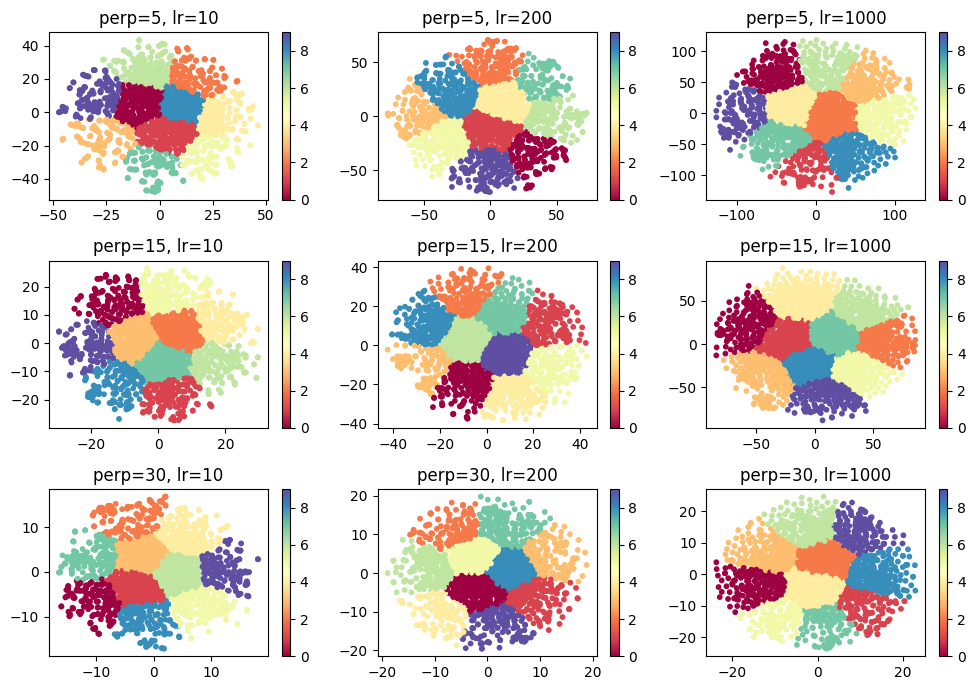

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Create a 3x3 grid
axes = axes.flatten()  # Flatten the axes for easy iteration

# Initialize a counter for subplots
subplot_index = 0

# Iterate through different perplexity and learning_rate combinations
for perplexity in [5, 15, 30]:
    for learning_rate in [10, 200, 1000]:
        # Create and fit t-SNE model
        tsne_model = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
        X_tsne = tsne_model.fit_transform(encoding_arr_2022[::5])
        
        # Assuming `cluster_embeddings` is your function to get cluster labels
        reduced_vectors = cluster_embeddings(X_tsne, n_clusters=10)
        
        # Plot the clusters in the corresponding subplot
        scatter = axes[subplot_index].scatter(X_tsne[:, 0], X_tsne[:, 1], c=reduced_vectors, cmap='Spectral', s=10)
        axes[subplot_index].set_title(f"perp={perplexity}, lr={learning_rate}")
        plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
        subplot_index += 1  # Move to the next subplot index

# Adjust plot layout and show
plt.tight_layout()
plt.show()

UMAP hyp test

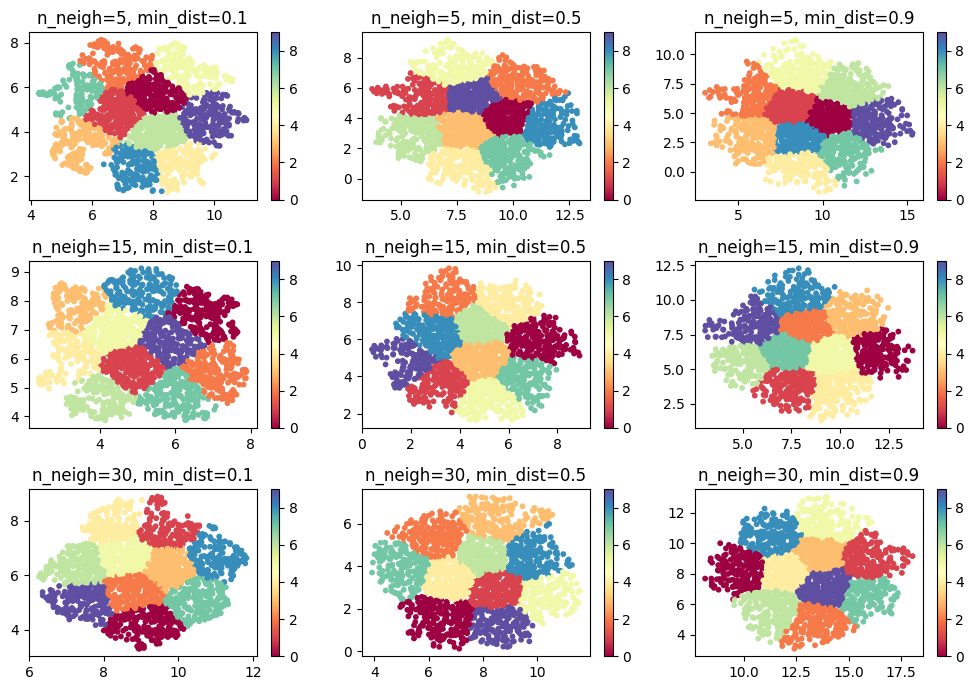

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Create a 3x3 grid
axes = axes.flatten()  # Flatten the axes for easy iteration

# Initialize a counter for subplots
subplot_index = 0

# Iterate through different perplexity and learning_rate combinations
for n_neighbors in [5, 15, 30]:
    for min_dist in [0.1, 0.5, 0.9]:
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        X_umap = umap_model.fit_transform(encoding_arr_2022[::5])
        
        
        # Assuming `cluster_embeddings` is your function to get cluster labels
        reduced_vectors,_ = cluster_embeddings(X_umap, n_clusters=10)
        
        # Plot the clusters in the corresponding subplot
        scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=reduced_vectors, cmap='Spectral', s=10)
        axes[subplot_index].set_title(f"n_neigh={n_neighbors}, min_dist={min_dist}")
        plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
        subplot_index += 1  # Move to the next subplot index

# Adjust plot layout and show
plt.tight_layout()
plt.show()

# kmeans hyp

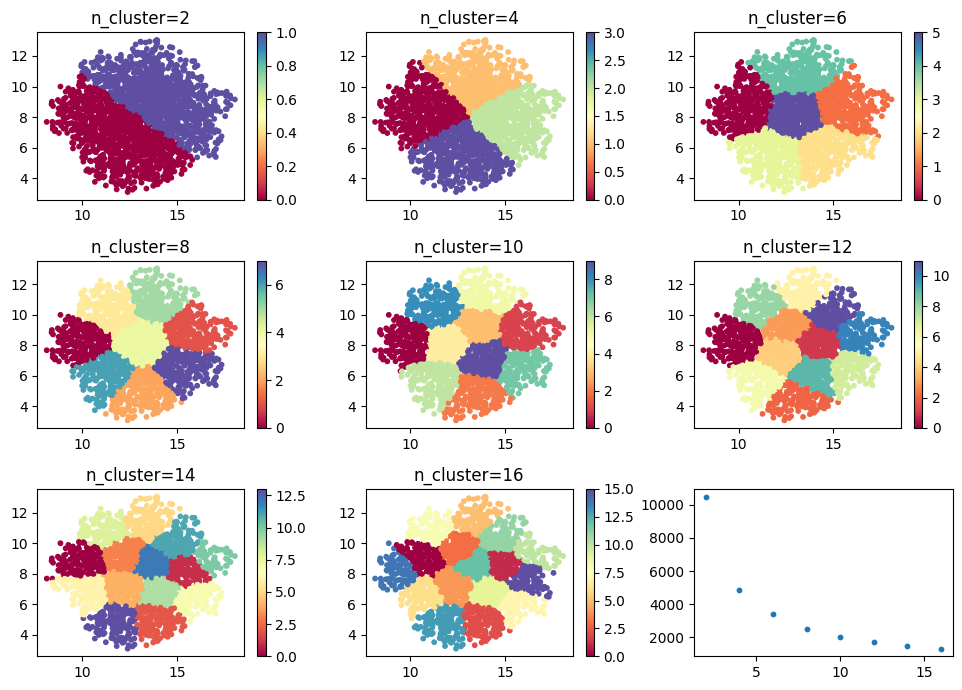

In [ ]:
# List of clustering models to loop over
models = [('KMeans', KMeans(n_clusters=n, random_state=42,n_init="auto")) for n in np.arange(2,2*9,2)]

# Set up the plot
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Adjust rows/columns based on the number of models
axes = axes.flatten()

inertia_arr = []
subplot_index = 0
# Loop through models, fit, and plot
for i, (name, model) in enumerate(models):
    # Fit the model
    model.fit(X_umap)
    labels = model.predict(X_umap)

    scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
    axes[subplot_index].set_title(f"n_cluster={np.arange(2,2*9,2)[i]}")
    plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
    subplot_index += 1  # Move to the next subplot index

    inertia_arr.append(model.inertia_)

axes[subplot_index].scatter(np.arange(2,2*9,2), inertia_arr, s=10)
plt.tight_layout()
plt.show()

# agglo

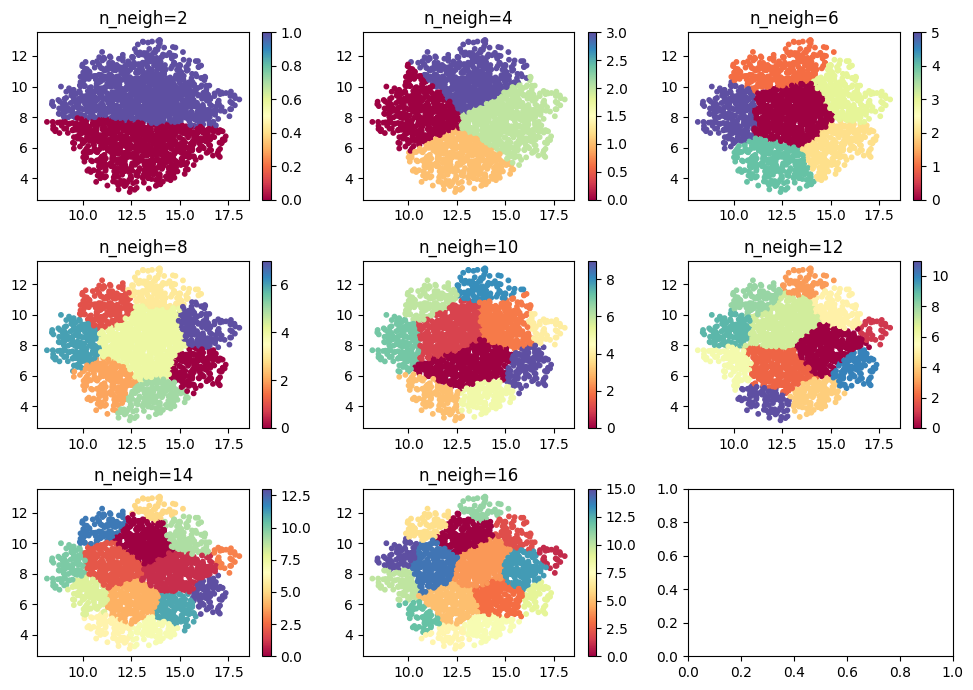

In [ ]:
# List of clustering models to loop over
from sklearn.cluster import AgglomerativeClustering
models = [('SpectralClustering', AgglomerativeClustering(n_clusters=n)) for n in np.arange(2,2*9,2)]

# Set up the plot
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Adjust rows/columns based on the number of models
axes = axes.flatten()

inertia_arr = []
subplot_index = 0
# Loop through models, fit, and plot
for i, (name, model) in enumerate(models):
    # Fit the model
    # model.(X_umap)
    labels = model.fit_predict(X_umap)
   
    scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
    axes[subplot_index].set_title(f"n_neigh={np.arange(2,2*9,2)[i]}")
    plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
    subplot_index += 1  # Move to the next subplot index

    # inertia_arr.append(model.inertia_)
    
# axes[subplot_index].scatter(np.arange(2,2*9,2), inertia_arr, s=10)
plt.tight_layout()
plt.show()

Birch

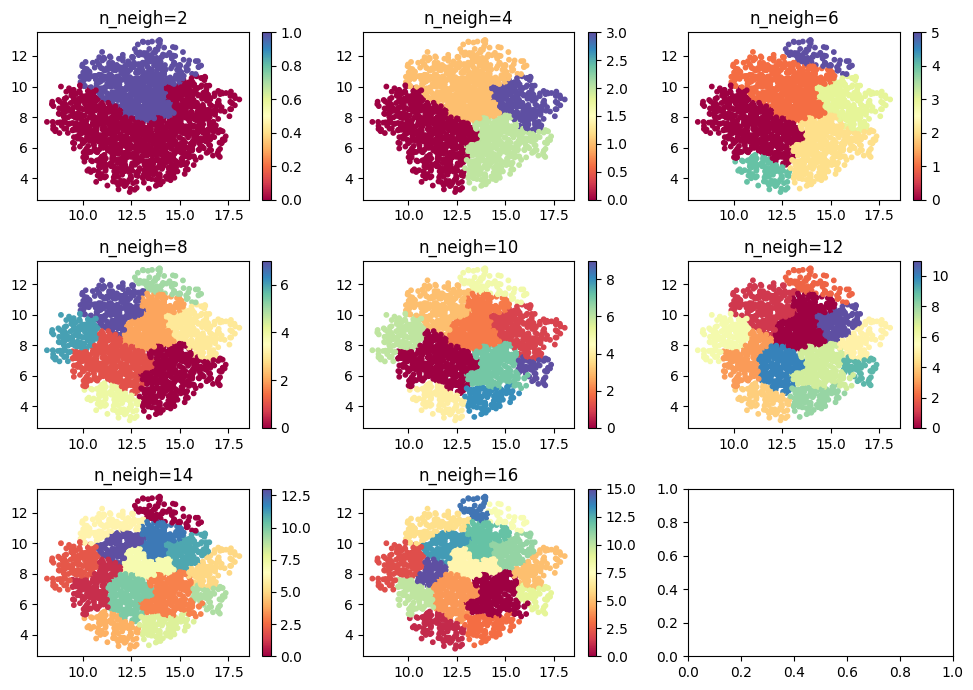

In [ ]:
# List of clustering models to loop over
from sklearn.cluster import Birch
models = [('DBSCAN', Birch(n_clusters=n)) for n in np.arange(2,2*9,2)]

# Set up the plot
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Adjust rows/columns based on the number of models
axes = axes.flatten()

inertia_arr = []
subplot_index = 0
# Loop through models, fit, and plot
for i, (name, model) in enumerate(models):
    # Fit the model
    # model.(X_umap)
    labels = model.fit_predict(X_umap)
   
    scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
    axes[subplot_index].set_title(f"n_neigh={np.arange(2,2*9,2)[i]}")
    plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
    subplot_index += 1  # Move to the next subplot index

    # inertia_arr.append(model.inertia_)
    
# axes[subplot_index].scatter(np.arange(2,2*9,2), inertia_arr, s=10)
plt.tight_layout()
plt.show()

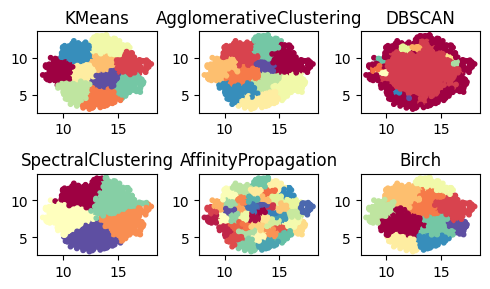

In [ ]:

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch


# List of clustering models to loop over
models = [
    ('KMeans', KMeans(n_clusters=10, random_state=42,n_init="auto")),
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=10)),
    ('DBSCAN', DBSCAN(eps=0.3, min_samples=10)),
    ('SpectralClustering', SpectralClustering(n_clusters=5, random_state=42, assign_labels='discretize')),
    ('AffinityPropagation', AffinityPropagation(random_state=42,max_iter=1000)),
    ('Birch', Birch(n_clusters=10))
]

X_umap = umap_model.fit_transform(encoding_arr_2022[::5])
        # reduced_vectors = cluster_embeddings(X_umap,n_clusters=10)

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # Adjust rows/columns based on the number of models
axes = axes.flatten()

# Loop through models, fit, and plot
for i, (name, model) in enumerate(models):
    # Fit the model
    model.fit(X_umap)
    
    # Get cluster labels
    if hasattr(model, 'labels_'):  # For models like Agglomerative, DBSCAN, etc.
        labels = model.labels_
    else:  # For models like KMeans that have `predict`
        labels = model.predict(X_umap)

    # Plot the clusters
    axes[i].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
    axes[i].set_title(name)

# Adjust plot layout and show
plt.tight_layout()
plt.show()


In [ ]:
stop

NameError: name 'stop' is not defined

# Papers per year

NameError: name 'year_arr' is not defined

# Distance between same concept between years in Encoding 

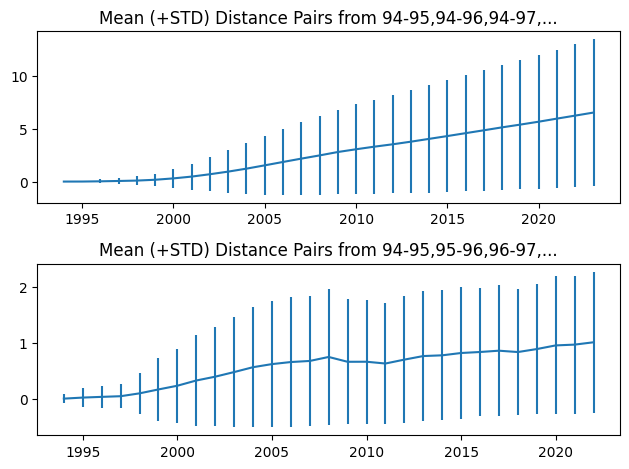

In [ ]:
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2, axis=-1)


plot_arr_from_0 = np.zeros((len(np.unique(year_arr)),len(c_encoding_arr)))
plot_arr_from_1 = np.zeros((len(np.unique(year_arr))-1,len(c_encoding_arr)))

for i,inx in enumerate(range(0,len(np.unique(year_arr)))):
    plot_arr_from_0[i] =  [euclidean_distance(e[0,:], e[inx,:])for e in c_encoding_arr]

for i,inx in enumerate(range(0,len(np.unique(year_arr))-1)):
    plot_arr_from_1[i] =  [euclidean_distance(e[inx,:], e[inx+1,:])for e in c_encoding_arr]


fig, axs = plt.subplots(2)
axs[0].errorbar(np.unique(year_arr), np.mean(plot_arr_from_0,axis=-1), yerr=np.std(plot_arr_from_0,axis=-1))
axs[1].errorbar(np.unique(year_arr)[:-1], np.mean(plot_arr_from_1,axis=-1), yerr=np.std(plot_arr_from_1,axis=-1))

axs[0].title.set_text('Mean (+STD) Distance Pairs from 94-95,94-96,94-97,...')
axs[1].title.set_text('Mean (+STD) Distance Pairs from 94-95,95-96,96-97,...')
fig.tight_layout()

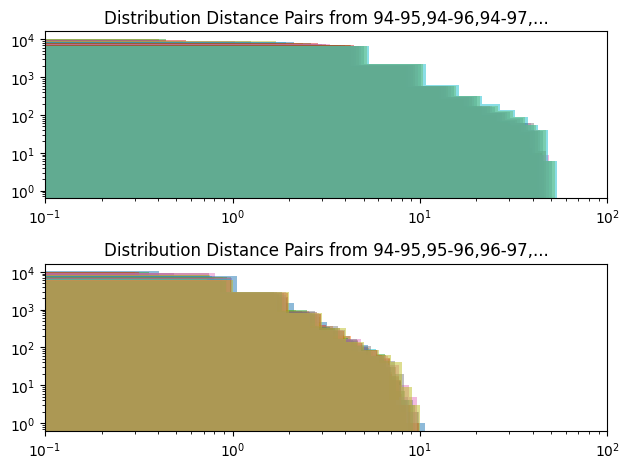

In [ ]:
fig, axs = plt.subplots(2)

for i in plot_arr_from_0:
    axs[0].hist(i,alpha=0.5)


for i in plot_arr_from_1:
    axs[1].hist(i,alpha=0.5)

axs[0].title.set_text('Distribution Distance Pairs from 94-95,94-96,94-97,...')
axs[1].title.set_text('Distribution Distance Pairs from 94-95,95-96,96-97,...')

axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_xlim(10**(-1),100)
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_xlim(10**(-1),100)
fig.tight_layout()

In [ ]:
print_dt = {}

for cnt, i in enumerate(plot_arr_from_0):
    
    args = np.argsort(i)[::-1][:5]
    val = np.sort(i)[::-1][:5]
    words = c_inx_arr[args]
    
    print_dt[np.unique(years)[cnt]] = words

df = pd.DataFrame()
for year, concepts in print_dt.items():
    df[year] = concepts

print(df)

                    1994                 1995              1996  \
0              ab_effect     quantum_mechanic     hilbert_space   
1            zx_calculus        hilbert_space       phase_space   
2  zitterbewegung_effect          phase_space   squeezed_vacuum   
3                zig_zag      squeezed_vacuum  quantum_mechanic   
4          zeta_function  projection_operator     photon_number   

                    1997                 1998                      1999  \
0            phase_shift          phase_shift       projection_operator   
1         relative_phase       dirac_equation      quantum_cryptography   
2          photon_number     quantum_mechanic  quantum_key_distribution   
3        squeezed_vacuum          phase_space          quantum_mechanic   
4  anharmonic_oscillator  projection_operator             photon_number   

                       2000                      2001               2002  \
0  nonlinear_coherent_state             casimir_force      casimir_for

In [ ]:

# def euclidean_distance(v1, v2):
#     return np.linalg.norm(v1 - v2, axis=-1)

# # Load data
# encoding_arr = np.load("c_encoding_arr.npy")
# years = np.load("saved_files/year_arr.npy")
# conc_arr = np.load("c_inx_arr.npy")

# # Get the number of unique years and number of concepts
# num_years = encoding_arr.shape[1]
# num_concepts = encoding_arr.shape[0]

# # Create a dictionary of concept embeddings indexed by year
# yearly_embeddings = {}
# for year_index, year in enumerate(np.unique(years)):
#     yearly_embeddings[year] = encoding_arr[:, year_index, :]

# # Initialize arrays to store aggregated statistics
# mean_distances_0 = []
# std_distances_0 = []
# mean_distances_1 = []
# std_distances_1 = []

# # Compute distances without repetition for each year and aggregate statistics
# for year_index, year in tqdm(enumerate(np.unique(years))):
#     distances = []
    
#     embeddings_dict = {i: encoding_arr[:,year,:][i] for i in range(encoding_arr[:,year,:].shape[0])}
#     for j in range(num_concepts):
#         for k in range(j + 1, num_concepts):
#             encoding_pair = np.concatenate((embeddings_dict[j], embeddings_dict[k]),axis=-1)
            
#             distances.append(euclidean_distance())


#     mean_distances_0.append(np.mean(distances))δt
#     std_distances_0.append(np.std(distances))

# # Compute distances without repetition for consecutive years and aggregate statistics
# # for i in tqdm(range(num_years - 1)):
# #     distances = []
# #     for j in range(num_concepts):
# #         for k in range(num_concepts):
# #             distances.append(euclidean_distance(encoding_arr[j, i], encoding_arr[j, i + 1]))
# #     mean_distances_1.append(np.mean(distances))
# #     std_distances_1.append(np.std(distances))

# # Plotting
# fig, axs = plt.subplots(2)
# axs[0].errorbar(np.unique(years), mean_distances_0, yerr=std_distances_0)
# axs[1].errorbar(np.unique(years)[:-1], mean_d

# axs[0].set_title('Mean (+STD) Distance Pairs from 94-95,94-96,94-97,...')
# axs[1].set_title('Mean (+STD) Distance Pairs from 94-95,95-96,96-97,...')
# fig.tight_layout()

# plt.show()


In [ ]:
# def euclidean_distance(v1, v2):
#     return np.linalg.norm(v1 - v2, axis=-1)

# encoding_arr = np.load("c_encoding_arr.npy")
# years = np.load("saved_files/year_arr.npy")
# conc_arr = np.load("c_inx_arr.npy")

# # Get the number of unique years and number of concepts
# num_years = encoding_arr.shape[1]
# num_concepts = encoding_arr.shape[0]

# # Initialize arrays to store aggregated statistics
# mean_distances_0 = []
# std_distances_0 = []
# mean_distances_1 = []
# std_distances_1 = []

# # Compute distances without repetition for each year and aggregate statistics
# for year_index in tqdm(range(num_years)):
#     distances = []
#     for j in range(num_concepts):
#         for k in range(j + 1, num_concepts):
#             distances.append(euclidean_distance(encoding_arr[j, year_index], encoding_arr[k, year_index]))
#     mean_distances_0.append(np.mean(distances))
#     std_distances_0.append(np.std(distances))

# # Compute distances without repetition for consecutive years and aggregate statistics
# for i in tqdm(range(num_years - 1)):
#     distances = []
#     for j in range(num_concepts):
#         for k in range(num_concepts):
#             distances.append(euclidean_distance(encoding_arr[j, i], encoding_arr[j, i + 1]))
#     mean_distances_1.append(np.mean(distances))
#     std_distances_1.append(np.std(distances))



# fig, axs = plt.subplots(2)
# axs[0].errorbar(np.unique(years), np.mean(plot_arr_from_0,axis=-1), yerr=np.std(plot_arr_from_0,axis=-1))
# axs[1].errorbar(np.unique(years)[:-1], np.mean(plot_arr_from_1,axis=-1), yerr=np.std(plot_arr_from_1,axis=-1))

# axs[0].title.set_text('Mean (+STD) Distance Pairs from 94-95,94-96,94-97,...')
# axs[1].title.set_text('Mean (+STD) Distance Pairs from 94-95,95-96,96-97,...')
# fig.tight_layout()

# Cluster

/home/felix/vscodeProjects/arxiv_nlp/arxiv_venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 50
Silhouette coefficient: -0.05
Inertia:779228.875
Silhouette values:
    Cluster 3: Size:4067 | Avg:0.12 | Min:0.02 | Max: 0.20
    Cluster 21: Size:1850 | Avg:-0.08 | Min:-0.14 | Max: 0.01
    Cluster 6: Size:38 | Avg:-0.08 | Min:-0.30 | Max: 0.13
    Cluster 38: Size:400 | Avg:-0.14 | Min:-0.28 | Max: 0.01
    Cluster 8: Size:114 | Avg:-0.14 | Min:-0.30 | Max: 0.01
    Cluster 2: Size:295 | Avg:-0.14 | Min:-0.29 | Max: 0.02
    Cluster 10: Size:495 | Avg:-0.15 | Min:-0.33 | Max: 0.05
    Cluster 25: Size:38 | Avg:-0.17 | Min:-0.32 | Max: -0.04
    Cluster 5: Size:7 | Avg:-0.18 | Min:-0.69 | Max: 0.09
    Cluster 22: Size:43 | Avg:-0.18 | Min:-0.44 | Max: 0.05
    Cluster 17: Size:363 | Avg:-0.19 | Min:-0.39 | Max: 0.03
    Cluster 48: Size:36 | Avg:-0.20 | Min:-0.46 | Max: -0.00
    Cluster 23: Size:145 | Avg:-0.20 | Min:-0.39 | Max: -0.00
    Cluster 43: Size:36 | Avg:-0.20 | Min:-0.40 | Max: -0.02
    Cluster 36: Size:60 | Avg:-0.20 | Min:-0.41 | Max: 0.03
    Cl

Most representative terms per cluster (based on centroids):
Cluster 0: entanglement bipartite multipartite_state 
Cluster 1: quantum_phase_transition thermodynamic_limit antiferromagnetic 
Cluster 2: secure_key_distribution quantum_key_distribution vernam_cipher 
Cluster 3: cantorus trm ngt 
Cluster 4: open_system open_quantum_system dynamic 
Cluster 5: smooth_min_entropy max_entropy dpi 
Cluster 6: unsupervised_machine_learning machine_learning deep_learning 
Cluster 7: estimation collective_measurement measurement 
Cluster 8: quantum_computational_algorithm qcpu combinatorial_search_problem 
Cluster 9: superconducting_transition_edge_sensor photon_detection single_photon_detection 
Cluster 10: hughstons quadratic_differential ac_phase 
Cluster 11: quantum_nonlinear_oscillator parametric_oscillator limit_cycle 
Cluster 12: canonical_coherent_state perelomov klauder 
Cluster 13: spin_coherence rare_earth_ion long_coherence_time 
Cluster 14: combinatorial_optimization_problem optimizati

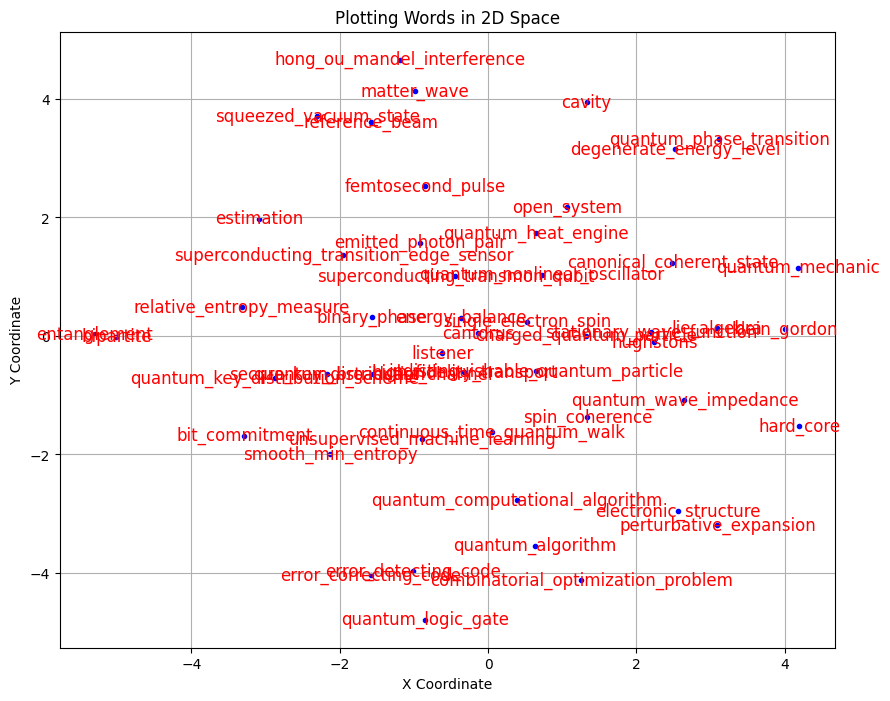

In [ ]:
# import matplotlib.pyplot as plt
# from openTSNE import TSNE

# def plot_words_in_2d_space(words):
#     """
#     Plots each word at its respective 2D coordinate.
    
#     Parameters:
#     coordinates (list of tuples): List of (x, y) pairs where each word should be plotted.
#     words (list of str): List of words to be plotted at each coordinate.
#     """

#     plt.figure(figsize=(10, 8))
#     for year in np.unique(year_arr):
#         Word2Vec.load("saved_models/model_year_{}.model".format(year))
#         vec_arr = []
#         for cnt, w in enumerate(words):
#             vec_arr.append(model.wv.get_vector(w))
#         vec_arr = np.array(vec_arr)
        
#         embed = TSNE(n_components=2, random_state=42, perplexity=10,n_iter=1000).fit(vec_arr)
            
    
#         # Extract x and y coordinates
#         x_coords = embed[:,0]
#         y_coords = embed[:,1]
        
#         # Create the plot
        
#         plt.scatter(x_coords, y_coords, color='blue', marker='.')
        
#         # Plot each word at its respective coordinate
#         for (x, y), word in zip(embed, words):
#             plt.text(x, y, word, fontsize=12, ha='center', va='center', color='red')
    



#     # Set plot titles and labels
#     plt.title('Plotting Words in 2D Space')
#     plt.xlabel('X Coordinate')
#     plt.ylabel('Y Coordinate')
    
#     # Show grid
#     plt.grid(True)
    
#     # Show plot
#     plt.show()



# plot_words_in_2d_space(np.random.choice(filtered_concept_dict,50))

# Latent Encoding over Time 

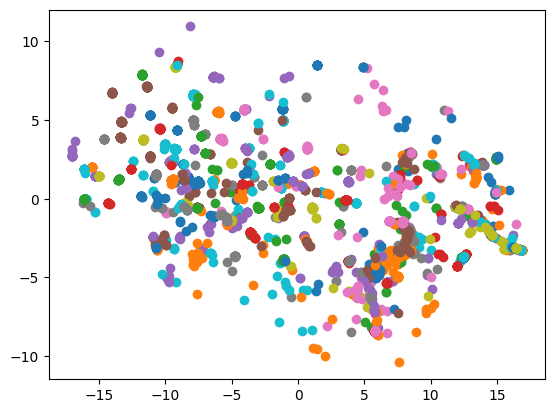

In [ ]:
loaded_w2v = Word2Vec.load("saved_models/re_model_year_{}.model".format(2022))
word_list = np.array(loaded_w2v.wv.most_similar("phase_transition", topn=200))[:,0]
sel_inx = [np.where(c_inx_arr==word_)[0] for word_ in word_list]
sel_inx = np.array([arr for arr in sel_inx if arr.size > 0])[:,0]

# sel_inx = np.random.randint(len(encoding_dat),size=100)
random_choice_encoding = c_encoding_arr[sel_inx]
random_choice_concepts = c_inx_arr[sel_inx]

y_arr = []
embed = TSNE(n_components=2, random_state=42, perplexity=10,n_iter=1000).fit(random_choice_encoding[:,0,:])
for inx in range(len(np.unique(year_arr))):
    Y = embed.transform(random_choice_encoding[:,inx,:])
    y_arr.append(Y)
    

y_arr = np.array(y_arr) 
for i in range(len(sel_inx)):
    plt.scatter(y_arr[:,i,0], y_arr[:,i,1])#, c=np.unique(year_arr))
    

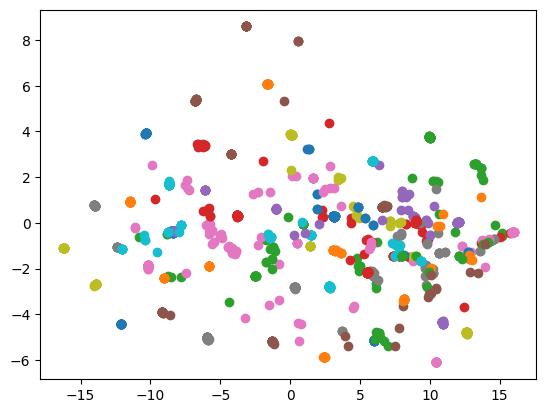

In [ ]:
sel_inx = np.random.randint(len(c_encoding_arr),size=50)
random_choice_encoding = c_encoding_arr[sel_inx]
random_choice_concepts = c_inx_arr[sel_inx]
y_arr = []
embed = TSNE(n_components=2, random_state=42, perplexity=5,n_iter=1000).fit(random_choice_encoding[:,0,:])
for inx in range(len(np.unique(year_arr))):
    Y = embed.transform(random_choice_encoding[:,inx,:])
    y_arr.append(Y)
    
y_arr = np.array(y_arr) 
for i in range(50):
    plt.scatter(y_arr[:,i,0], y_arr[:,i,1])#, c=np.unique(year_arr))

In [ ]:
# sel_inx = np.random.randint(len(c_encoding_arr),size=100)
# random_choice_encoding = c_encoding_arr[sel_inx]
# random_choice_concepts = c_inx_arr[sel_inx]

# Y = TSNE(n_components=2, random_state=42, perplexity=5,n_iter=100).fit(random_choice_encoding[:,0,:])

# plt.scatter(Y[:,0], Y[:,1], c=np.arange(100))

In [ ]:
# years, numpapers_y = np.unique(year_arr,return_counts=True)
# fig, ax = plt.subplots(figsize=(3.5,3))

# ax.plot( np.arange(len(numpapers_y))[:-1], numpapers_y[:-1], '-o', markersize=3 )
# ax.set_xticks( list(range(len(years))[::3]))
# ax.set_xticklabels( years[::3], rotation=45 )
# ax.set_yscale("log")

# ax2 = fig.add_axes([0.475, 0.25+0.1, 0.25+0.1, 0.25])
# ax2.plot(np.arange(len(numpapers_y))[:-1][::2], cumulative_sum[:-1][::2], '-o', markersize=3)

# ax2.set_xticks( list(range(len(years))[::5]))
# ax2.set_xticklabels( years[::5], rotation=45 )
# ax2.set_yscale("log")

# Most connected concepts

In [ ]:
# def replace_strings_with_indices(data, concept_to_index):
#     # Create a new dictionary to store the converted data
#     indexed_data = {}
    
#     # Iterate through the outer dictionary
#     for concept1, nested_dict in data.items():
#         # Replace the concept1 string with its index
#         # print(concept_to_index[concept1])
#         index1 = concept_to_index[concept1][0]
#         indexed_data[index1] = {}
        
#         # Iterate through the inner dictionary
#         for concept2, years in nested_dict.items():
#             # Replace the concept2 string with its index
            
#             index2 = concept_to_index[concept2][0]
#             indexed_data[index1][index2] = years
    
#     return indexed_data


# concept_to_indices = {concept: np.where(concept_filtered_arr == concept)[0] for concept in np.unique(concept_filtered_arr)}
# index_co_occurrences = replace_strings_with_indices(word_co_occurrences, concept_to_indices)

# def create_graph_from_dict(data):
#     # Create an empty graph
#     G = nx.Graph()
    
#     # Iterate through the outer dictionary
#     for concept1, nested_dict in data.items():
#         # Iterate through the inner dictionary
#         for concept2, years in nested_dict.items():
#             # If the edge already exists, add to the weight and append years
#             if G.has_edge(concept1, concept2):
#                 G[concept1][concept2]['weight'] += len(years)
#                 G[concept1][concept2]['years'].extend(years)
#             else:
#                 # Add a new edge with the weight and list of years
#                 G.add_edge(concept1, concept2, weight=len(years), years=years)
    
#     # Remove duplicate years
#     for u, v in G.edges():
#         G[u][v]['years'] = list(set(G[u][v]['years']))
    
#     return G

# def convert_years_to_days_since_1990(years):
#     base_date = datetime(1990, 1, 1)
#     days_since_1990 = [(datetime(year, 1, 1) - base_date).days for year in years]
#     return days_since_1990

# def save_graph_edges(graph, filename):
#     # Create a list of concepts and assign indices
#     concepts = list(graph.nodes())
#     concept_indices = {concept: idx for idx, concept in enumerate(concepts)}
    
#     # Create the edge list in the specified format
#     edge_list = []
#     for u, v, data in graph.edges(data=True):
#         idx1 = concept_indices[u]
#         idx2 = concept_indices[v]
#         years = data['years']
#         days = convert_years_to_days_since_1990(years)
#         for day in days:
#             edge_list.append([idx1, idx2, day])
    
#     # Save the edge list as a .pkl file
#     with open(filename, 'wb') as f:
#         pickle.dump(edge_list, f)


# graph = create_graph_from_dict(word_co_occurrences)
# save_graph_edges(graph, 'graph_edges.pkl')

# Print the edge list to verify
with open('saved_files/graph_edges.pkl', 'rb') as f:
    edge_list = pickle.load(f)
    print(edge_list[0])


graph = nx.Graph()
graph.add_weighted_edges_from(edge_list)


[0, 1, 11323]


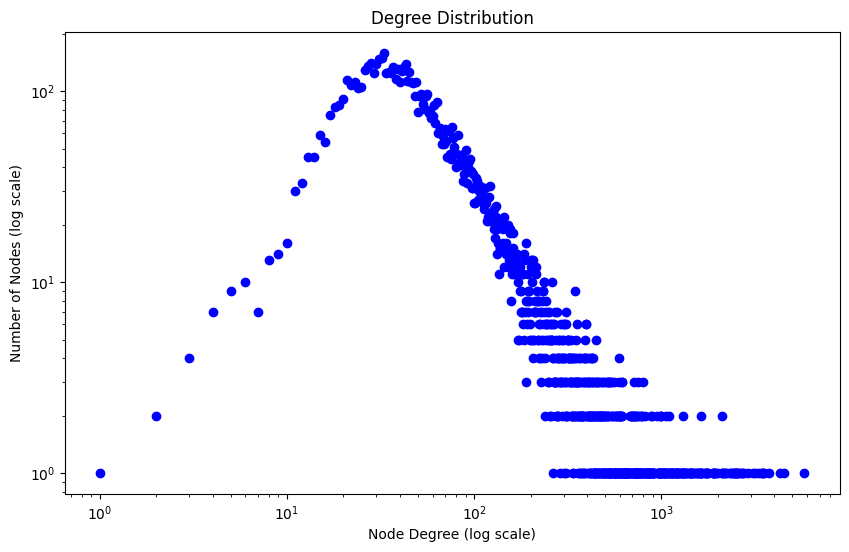

In [ ]:
# Step 2: Compute the degree of each node
from collections import Counter

degree_sequence = [d for n, d in graph.degree()]

# Step 3: Calculate the degree distribution
degree_count = Counter(degree_sequence)
degree, count = zip(*degree_count.items())

# Step 4: Plot the distribution with log scales on both axes
plt.figure(figsize=(10, 6))
plt.scatter(degree, count, c='blue')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Node Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Degree Distribution')

# plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
# Find the top 20 nodes with the lowest and highest degrees
sorted_nodes_by_degree = sorted(graph.degree(), key=lambda x: x[1])

# Top 20 nodes with the lowest degrees
top_20_lowest_degree_nodes = sorted_nodes_by_degree[:10]

# Top 20 nodes with the highest degrees
top_20_highest_degree_nodes = sorted_nodes_by_degree[-200:][::-1]

print("Highest Degree")
for c,cnt in top_20_highest_degree_nodes:
    
    print(c_inx_arr[c], cnt)

print("Lowest Degree")
for c,cnt in top_20_lowest_degree_nodes:
    print(c_inx_arr[c], cnt)



# # Step 3: Calculate the degree distribution
# degree_count = Counter(degree_sequence)
# degree, count = zip(*degree_count.items())

Highest Degree
adiabatic_quantum_evolution 5802
auto_correlation 4538
atomic_collective_excitation 4294
abstract_model 3740
abelian_subgroup 3546
ab_initio 3475
atomic_beam 3459
arithmetic_operation 3411
belief_propagation_decoding 3300
angular_momentum_theory 3181
absorbing_boundary_condition 3069
adiabatic_transport 2895
atomic_thermal_motion 2776
chromatic_dispersion 2704
adiabatic_method 2680
average_photon_number 2658
artificial_intelligence 2599
achievable_efficiency 2551
antiferromagnetic_chain 2534
asymptotic_convergence 2512
bistable_behavior 2505
coherence_transfer 2502
analytic_representation 2469
base_field 2437
classification_performance 2400
breit_wigner 2370
bessel_beam 2365
analytical_solution 2311
carbon_nanotube 2238
amplitude_estimation_algorithm 2187
bacon_shor_code 2180
blind_quantum_computing 2140
adjacency_matrix 2105
action_integral 2105
basis_set 2103
action_angle 2095
biological_molecule 1997
adiabatic_preparation 1964
combinatorial_optimization 1927
adiabatic

In [ ]:
def similarity_cosine(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def cosine_distance(v1, v2):
    return 1-similarity_cosine(v1, v2)

# word_list = ["entangled_state",
#              "magnetic_field",
#              "ground_state",
#              "quantum_correlation",
#              "phase_transition",
#              "bell_inequality",
#              "non_trivial", 
#              "ab_initio", 
#              "thermalization"
#              ]

word_list = ["artificial_intelligence",
"adiabatic_preparation",
"carbon_nanotube",
"combinatorial_optimization",
"laser_light",
"adversarial_attack",
"coherence_measurement",
"cauchy_schwarz_inequality",
"adiabatic_quantum_evolution",
"bayesian_filter",
"bipartite_quantum_system",
"auto_correlation",
"adiabatic_method",
"antiferromagnetic_chain",
"analytic_representation",
"classification_performance",
]


# Initialize lists to track the top 20 increases and decreases
top_increase_total_concepts = [[] for _ in range(len(word_list))]
top_decrease_total_concepts = [[] for _ in range(len(word_list))]
top_increase_relative_concepts = [[] for _ in range(len(word_list))]
top_decrease_relative_concepts = [[] for _ in range(len(word_list))]

for cnt, c_1 in tqdm(enumerate(word_list)):
    print("Currently:", c_1)
    _inx_1 = np.where(c_inx_arr == c_1)[0]
    for _inx_2, c_2 in enumerate(c_inx_arr):
        _inx_2 = np.array([_inx_2])
        
        encoding1 = c_encoding_arr[_inx_1][0]
        encoding2 = c_encoding_arr[_inx_2][0]
        
        # Compute cosine similarities for each year
        similarity_per_year = [cosine_distance(v1, v2) for (v1, v2) in zip(encoding1, encoding2)]

        # distance_change = similarity_per_year[-1] - similarity_per_year[len(similarity_per_year)//2] 
        distance_change = np.max(similarity_per_year) - np.min(similarity_per_year)
        
        relative_change = distance_change / similarity_per_year[0] if similarity_per_year[0] != 0 else 0  # Avoid division by zero

        # Update top increase/decrease concepts if applicable
        if len(top_increase_total_concepts[cnt]) < 30:
            top_increase_total_concepts[cnt].append((c_1, c_2, distance_change))
            top_decrease_total_concepts[cnt].append((c_1, c_2, distance_change))
            top_increase_relative_concepts[cnt].append((c_1, c_2, relative_change))
            top_decrease_relative_concepts[cnt].append((c_1, c_2, relative_change))
        else:
            top_increase_total_concepts[cnt].sort(key=lambda x: x[2], reverse=True)
            top_decrease_total_concepts[cnt].sort(key=lambda x: x[2])
            top_increase_relative_concepts[cnt].sort(key=lambda x: x[2], reverse=True)
            top_decrease_relative_concepts[cnt].sort(key=lambda x: x[2])
            
            if distance_change > top_increase_total_concepts[cnt][-1][2]:
                top_increase_total_concepts[cnt][-1] = (c_1, c_2, distance_change)
            if distance_change < top_decrease_total_concepts[cnt][-1][2]:
                top_decrease_total_concepts[cnt][-1] = (c_1, c_2, distance_change)
            if relative_change > top_increase_relative_concepts[cnt][-1][2]:
                top_increase_relative_concepts[cnt][-1] = (c_1, c_2, relative_change)
            if relative_change < top_decrease_relative_concepts[cnt][-1][2]:
                top_decrease_relative_concepts[cnt][-1] = (c_1, c_2, relative_change)

# After the loop, ensure the final top 20 lists are sorted correctly
for i in range(len(word_list)):
    top_increase_total_concepts[i] = sorted(top_increase_total_concepts[i], key=lambda x: x[2], reverse=True)[:20]
    top_decrease_total_concepts[i] = sorted(top_decrease_total_concepts[i], key=lambda x: x[2])[:20]
    top_increase_relative_concepts[i] = sorted(top_increase_relative_concepts[i], key=lambda x: x[2], reverse=True)[:20]
    top_decrease_relative_concepts[i] = sorted(top_decrease_relative_concepts[i], key=lambda x: x[2])[:20]

# Now `top_increase_total_concepts`, `top_decrease_total_concepts`, `top_increase_relative_concepts`, and `top_decrease_relative_concepts`
# will contain the top 20 increases and decreases for each concept pair.


0it [00:00, ?it/s]

Currently: artificial_intelligence


1it [00:01,  1.78s/it]

Currently: adiabatic_preparation


2it [00:03,  1.66s/it]

Currently: carbon_nanotube


3it [00:05,  1.71s/it]

Currently: combinatorial_optimization


4it [00:06,  1.68s/it]

Currently: laser_light


5it [00:08,  1.70s/it]

Currently: adversarial_attack


6it [00:10,  1.64s/it]

Currently: coherence_measurement


7it [00:11,  1.64s/it]

Currently: cauchy_schwarz_inequality


8it [00:13,  1.61s/it]

Currently: adiabatic_quantum_evolution


9it [00:14,  1.59s/it]

Currently: bayesian_filter


10it [00:16,  1.56s/it]

Currently: bipartite_quantum_system


11it [00:17,  1.53s/it]

Currently: auto_correlation


12it [00:19,  1.54s/it]

Currently: adiabatic_method


13it [00:20,  1.53s/it]

Currently: antiferromagnetic_chain


14it [00:22,  1.54s/it]

Currently: analytic_representation


15it [00:23,  1.57s/it]

Currently: classification_performance


16it [00:25,  1.60s/it]


In [ ]:
# Print top 10 concepts with the largest increase and decrease in distance
print("Top 10 concepts with the largest total increase in distance:")
for con in top_increase_total_concepts:
    for concept in con:
        print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")

print("\nTop 10 concepts with the largest total decrease in distance:")
for con in top_decrease_total_concepts:
    for concept in con:
        print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")
# Print top 10 concepts with the largest increase and decrease in distance
# print("Top 10 concepts with the largest relative increase in distance:")

# for con in top_increase_relative_concepts:
#     for concept in con:
#         print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")

# print("\nTop 10 concepts with the largest relative decrease in distance:")
# for con in top_decrease_relative_concepts:
#     for concept in con:
#         print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")

Top 10 concepts with the largest total increase in distance:
Concept pair: artificial_intelligence, np_problem, Distance change: 1.43
Concept pair: artificial_intelligence, xor_gate, Distance change: 1.41
Concept pair: artificial_intelligence, extended_hilbert_space, Distance change: 1.35
Concept pair: artificial_intelligence, quantum_robot, Distance change: 1.35
Concept pair: artificial_intelligence, n_dimensional_space, Distance change: 1.32
Concept pair: artificial_intelligence, spin_coherent_state, Distance change: 1.31
Concept pair: artificial_intelligence, shannon_information, Distance change: 1.29
Concept pair: artificial_intelligence, boolean_logic, Distance change: 1.27
Concept pair: artificial_intelligence, halting_problem, Distance change: 1.27
Concept pair: artificial_intelligence, tensor_power, Distance change: 1.25
Concept pair: artificial_intelligence, dirac_particle, Distance change: 1.25
Concept pair: artificial_intelligence, square_integrable_function, Distance change

In [ ]:
stop

In [ ]:
# def test_pair(c1,c2):
#     inx1 = np.where(c_inx_arr==c1)[0]
#     inx2 = np.where(c_inx_arr==c2)[0]
#     return  [cosine_distance(c_encoding_arr[inx1][0][i],c_encoding_arr[inx2][0][i]) for i,year in enumerate(np.unique(year_arr))]

# plt.plot(test_pair("entangled_state" , "von_neumann_entropy"))


In [ ]:
# def cosine_distance(A, B):
#     # Compute the dot product between A and B
#     dot_product = np.dot(A, B)
    
#     # Compute the L2 norms (magnitudes) of A and B
#     norm_A = np.linalg.norm(A)
#     norm_B = np.linalg.norm(B)
    
#     # Compute the cosine similarity
#     cosine_similarity = dot_product / (norm_A * norm_B)
    
#     # Compute the cosine distance
#     cosine_distance = 1 - cosine_similarity
    
#     return cosine_distance




data_dict = {
    "entangled_state":{"bell_measurement":{},"tripartite_quantum_state":{},"resonance_interaction":{},"positive_lyapunov_exponent":{},"liouville_equation":{},"noether_theorem":{}},
    "magnetic_field":{"drift_velocity":{},"conserved_quantity":{},"spin_coupling":{},"jacobi_matrix":{},"schroedinger_operator":{},"toffoli_gate":{}},
    "ground_state":{"excitation_gap":{},"slater_determinant":{},"matrix_product_state_representation":{},"deformation_quantization":{},"reversible_computing":{},"logic_gate":{}},
    "quantum_correlation":{"gaussian_quantum_discord":{},"jaynes_principle":{},"quantum_indistinguishability":{},"variational_principle":{},"superconducting_circuit":{},"differential_equation":{}},
    "phase_transition":{"quantum_defect":{},"quantum_defect":{},"quantum_zeno_effect":{},"modular_exponentiation":{},"group_transformation":{},"ladder_operator":{}},
    "bell_inequality":{"maximal_quantum_violation":{},"multiple_system":{},"quantum_non_locality":{},"heterodyne_detection_scheme":{},"mode_squeezing":{},"phase_space":{}},
}

for concept_1, dict_1 in data_dict.items():
    selw_inx = np.where(c_inx_arr==concept_1)[0]
    for concept_2, dict_2 in dict_1.items():
        
        selc_inx = np.where(c_inx_arr==concept_2)[0]

        try:
            data_dict[concept_1][concept_2] = {year:cosine_distance(c_encoding_arr[selw_inx][0][i],c_encoding_arr[selc_inx][0][i]) for i,year in enumerate(np.unique(year_arr))}
        except:
            print(concept_1,concept_2,"fails")
            

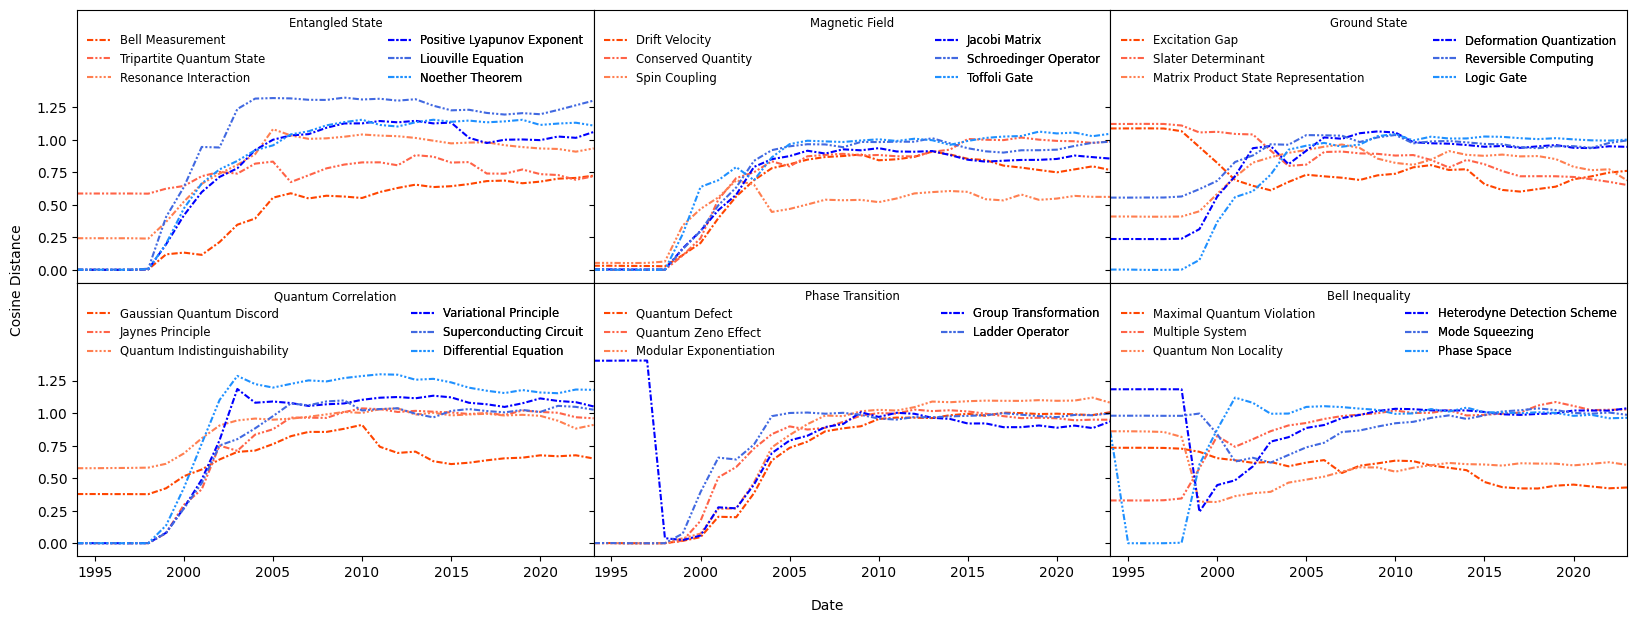

In [ ]:
# Define colors
red_hues = ['#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FFA07A']
blue_hues = ['#0000FF', '#4169E1', '#1E90FF', '#00BFFF', '#87CEFA']

linestyles = [
    (0, (3, 1, 1, 1)),         # dash dot dash
    (0, (3, 1, 1, 1, 1, 1)),   # dash dot dot dash
    (0, (3, 1, 1, 1, 1, 1, 1, 1)), # dash dot dot dot dash
    (0, (3, 1, 1, 1, 1, 1, 1, 1, 1, 1)), # dash dot dot dot dot dash
    (0, (3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))  # dash dot dot dot dot dot dash
]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 7.1), sharex=True, sharey=True)
axes = axes.flatten()

main_words = list(data_dict.keys())
years = sorted(list(data_dict[main_words[0]][list(data_dict[main_words[0]].keys())[0]].keys()))

for i, main_word in enumerate(main_words):
    ax = axes[i]
    red_lines = []
    blue_lines = []
    for j, (related_word, distances) in enumerate(data_dict[main_word].items()):
        distances_over_time = [distances[year] for year in years]
        color = red_hues[j % 3] if j < 3 else blue_hues[j % 3]
        linestyle = linestyles[j % 3] 
        
        label = related_word
        line, = ax.plot(years, distances_over_time, color=color, linestyle=linestyle, label=label)
        
        if j < 3:
            red_lines.append(line)
        else:
            blue_lines.append(line)
    
    ax.text(0.5, 0.975, main_word.replace("_"," ").title(), horizontalalignment='center', verticalalignment='top', transform=ax.transAxes, fontsize="small")#, bbox=dict(facecolor='lightblue', alpha=0.5))
    ax.set_ylim(0, 1)
    ax.set_xlim(min(years), max(years))
    
    red_legend_handles = [Line2D([0], [0], color=red_hues[j % 3], linestyle=linestyles[j % 3], label=related_word.replace("_"," ").title() )
                          for j, related_word in enumerate(data_dict[main_word].keys()) if j < 3]

    blue_legend_handles = [Line2D([0], [0], color=blue_hues[j % 3], linestyle=linestyles[j % 3], label=related_word.replace("_"," ").title())
                           for j, related_word in enumerate(data_dict[main_word].keys()) if j >= 3]
    
    red_legend = ax.legend(handles=red_legend_handles, loc='upper left', fontsize='small',frameon=False,bbox_to_anchor=(0, 0.95))
    blue_legend = ax.legend(handles=blue_legend_handles, loc='upper right', fontsize='small',frameon=False, bbox_to_anchor=(1, 0.95))
    ax.add_artist(red_legend)
    ax.add_artist(blue_legend)
    ax.set_ylim([-0.1,2])
    ax.set_yticks([0,0.25,0.50,0.75,1,1.25])
    # ax.set_yscale("log")
    

fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.095, 0.5, 'Cosine Distance', ha='center', va='center', rotation='vertical')
# fig.suptitle('Cosine Distances of Words Over Time', fontsize=16)

# Adjust layout to remove gaps
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()
